# Predicting players rating

In this project you are going to predict the overall rating of soccer player based on their attributes such as 'crossing', 'finishing etc. The dataset you are going to use is from European Soccer Database (https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than 10,000 players for European professional soccer seasons from 2008 to 2016. Download the data in the same folder and run the following commmand to get it in the environment

About the Dataset The ultimate Soccer database for data analysis and machine learning The dataset comes in the form of an SQL database and contains statistics of about 25,000 footballmatches, from the top football league of 11 European Countries. It covers seasons from 2008 to 2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations,with player names and a pair of coordinates to indicate their position on the pitch.

+25,000 matches +10,000 players 11 European Countries with their lead championship Seasons 2008 to 2016 Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates Team line up with squad formation (X, Y coordinates) Betting odds from up to 10 providers Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video games. It is not just the stats that come with a new version of the game but also the weekly updates. So for instance if a player has performed poorly over a period of time and his stats get impacted in FIFA, you would normally see the same in the dataset.


In [1]:
import sqlite3
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle


In [2]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [3]:
cursor = cnx.cursor()
table_names = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [4]:
df_player = pd.read_sql_query("SELECT * FROM Player", cnx)
df_player_att = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
df_match = pd.read_sql_query("SELECT * FROM Match", cnx)
df_league = pd.read_sql_query("SELECT * FROM League", cnx)
df_country = pd.read_sql_query("SELECT * FROM Country", cnx)
df_team = pd.read_sql_query("SELECT * FROM Team", cnx)
df_team_att = pd.read_sql_query("SELECT * FROM Team_Attributes", cnx)

In [5]:
#Analyzing Country Table
print(90*"-")
print("Country Table")
print(df_country.describe())
print(90*"-")
print(df_country.isnull().sum(axis=0))
print(90*"-")
print(df_country)

------------------------------------------------------------------------------------------
Country Table
                 id
count     11.000000
mean   12452.090909
std     8215.308472
min        1.000000
25%     6289.000000
50%    13274.000000
75%    18668.000000
max    24558.000000
------------------------------------------------------------------------------------------
id      0
name    0
dtype: int64
------------------------------------------------------------------------------------------
       id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland


In [6]:
#Analyzing League Table
print(90*"-")
print("League Table")
print(df_league.describe())
print(90*"-")
print(df_league.isnull().sum(axis=0))
print(90*"-")
print(df_league)


------------------------------------------------------------------------------------------
League Table
                 id    country_id
count     11.000000     11.000000
mean   12452.090909  12452.090909
std     8215.308472   8215.308472
min        1.000000      1.000000
25%     6289.000000   6289.000000
50%    13274.000000  13274.000000
75%    18668.000000  18668.000000
max    24558.000000  24558.000000
------------------------------------------------------------------------------------------
id            0
country_id    0
name          0
dtype: int64
------------------------------------------------------------------------------------------
       id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722  

In [7]:
#Analyzing Team Table
print(90*"-")
print(df_team.describe())
print(90*"-")
print(df_team.isnull().sum(axis=0))
print(df_team[df_team.loc[:,'team_fifa_api_id'].isnull()])
df_team_updated = df_team[~df_team.loc[:,'team_fifa_api_id'].isnull()]
my_team = dict()
for i,j in list(df_team_updated.iloc[:,3:].groupby('team_short_name')):
    my_team[i] = j.iloc[:,0].values.tolist()

#List of teams with similar short team names 
print("List of teams with similar short team names") 
print("List of teams with similar short team names") 
print("List of teams with similar short team names")    
print({k:v for k,v in my_team.items() if len(v) > 1})

------------------------------------------------------------------------------------------
                 id    team_api_id  team_fifa_api_id
count    299.000000     299.000000        288.000000
mean   23735.301003   12340.521739      21534.305556
std    15167.914719   25940.411135      42456.439408
min        1.000000    1601.000000          1.000000
25%     9552.500000    8349.000000        178.750000
50%    22805.000000    8655.000000        673.500000
75%    36250.500000    9886.500000       1910.750000
max    51606.000000  274581.000000     112513.000000
------------------------------------------------------------------------------------------
id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64
        id  team_api_id  team_fifa_api_id                team_long_name  \
8        9         7947               NaN                 FCV Dender EH   
14      15         4049               NaN                      

In [8]:
#Analyzing Team Attributes Table
print(90*"-")
print(df_team_att.describe())
print(90*"-")
print(df_team_att.isnull().sum(axis=0))

df_team_att_updated1 = df_team_att.drop(['buildUpPlayDribbling'],axis = 1)
tat = df_team_att_updated1.loc[:,df_team_att_updated1.columns.tolist()[3:]]

------------------------------------------------------------------------------------------
                id  team_fifa_api_id    team_api_id  buildUpPlaySpeed  \
count  1458.000000       1458.000000    1458.000000       1458.000000   
mean    729.500000      17706.982167    9995.727023         52.462277   
std     421.032659      39179.857739   13264.869900         11.545869   
min       1.000000          1.000000    1601.000000         20.000000   
25%     365.250000        110.000000    8457.750000         45.000000   
50%     729.500000        485.000000    8674.000000         52.000000   
75%    1093.750000       1900.000000    9904.000000         62.000000   
max    1458.000000     112513.000000  274581.000000         80.000000   

       buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
count            489.000000         1458.000000            1458.000000   
mean              48.607362           48.490398              52.165295   
std                9.678290  

In [9]:
#Analyzing Player Table

print(90*"~")
print(df_player.describe())
print(90*"~")
print(df_player.isnull().sum(axis=0))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 id  player_api_id  player_fifa_api_id        height  \
count  11060.000000   11060.000000        11060.000000  11060.000000   
mean    5537.511392  156582.427215       165664.910488    181.867445   
std     3197.692647  160713.700624        58649.928360      6.369201   
min        1.000000    2625.000000            2.000000    157.480000   
25%     2767.750000   35555.500000       151889.500000    177.800000   
50%     5536.500000   96619.500000       184671.000000    182.880000   
75%     8306.250000  212470.500000       203883.250000    185.420000   
max    11075.000000  750584.000000       234141.000000    208.280000   

             weight  
count  11060.000000  
mean     168.380289  
std       14.990217  
min      117.000000  
25%      159.000000  
50%      168.000000  
75%      179.000000  
max      243.000000  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [10]:
print("Cardinality of Feature: Height - {:0.3f}%".format( \
        100 * (len(np.unique(df_player.loc[:,'height'])) / len(df_player.loc[:,'height']))))
print("Cardinality of Feature: Weight - {:0.3f}%".format( \
        100 * (len(np.unique(df_player.loc[:,'weight'])) / len(df_player.loc[:,'weight']))))

#Analyzing Player Attributes Table
print(90*"~")
print(df_player_att.describe())

Cardinality of Feature: Height - 0.181%
Cardinality of Feature: Weight - 0.452%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 id  player_fifa_api_id  player_api_id  overall_rating  \
count  183978.00000       183978.000000  183978.000000   183142.000000   
mean    91989.50000       165671.524291  135900.617324       68.600015   
std     53110.01825        53851.094769  136927.840510        7.041139   
min         1.00000            2.000000    2625.000000       33.000000   
25%     45995.25000       155798.000000   34763.000000       64.000000   
50%     91989.50000       183488.000000   77741.000000       69.000000   
75%    137983.75000       199848.000000  191080.000000       73.000000   
max    183978.00000       234141.000000  750584.000000       94.000000   

           potential       crossing      finishing  heading_accuracy  \
count  183142.000000  183142.000000  183142.000000     183142.000000   
mean       73.4603

In [11]:
print(90*"~")

print(df_player_att.isnull().sum(axis=0))
print(np.unique(df_player_att.dtypes.values))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision       

In [12]:
corr2 = df_player_att.select_dtypes(include =['float64','int64']).loc[:,df_player_att.select_dtypes(include =['float64','int64']).columns[3:]].corr()
print(df_player_att['attacking_work_rate'].value_counts())
print(100*'~')
print(df_player_att['defensive_work_rate'].value_counts())

print(100*'~')

medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [13]:
df_player_att.loc[~(df_player_att['attacking_work_rate'].\
                                                  isin(['medium','high','low'])\
                       | df_player_att['defensive_work_rate'].isin(['medium','high','low'])),:].head()
df_player_att_updated1 = df_player_att.loc[(df_player_att['attacking_work_rate'].\
                                                  isin(['medium','high','low'])\
                       & df_player_att['defensive_work_rate'].isin(['medium','high','low'])),:]

In [14]:
att_work_rate = df_player_att_updated1.groupby('attacking_work_rate').size().values.tolist()
def_work_rate = df_player_att_updated1.groupby('defensive_work_rate').size().values.tolist()

In [15]:
print("Attacking work rate factor, Medium, accounts for: {:0.3f}% of features".format(100 * att_work_rate[2]/np.sum(att_work_rate)))
print("Defensive work rate factor, Medium, accounts for: {:0.3f}% of features".format(100 * def_work_rate[2]/np.sum(def_work_rate)))

Attacking work rate factor, Medium, accounts for: 70.885% of features
Defensive work rate factor, Medium, accounts for: 74.230% of features


<IPython.core.display.Javascript object>


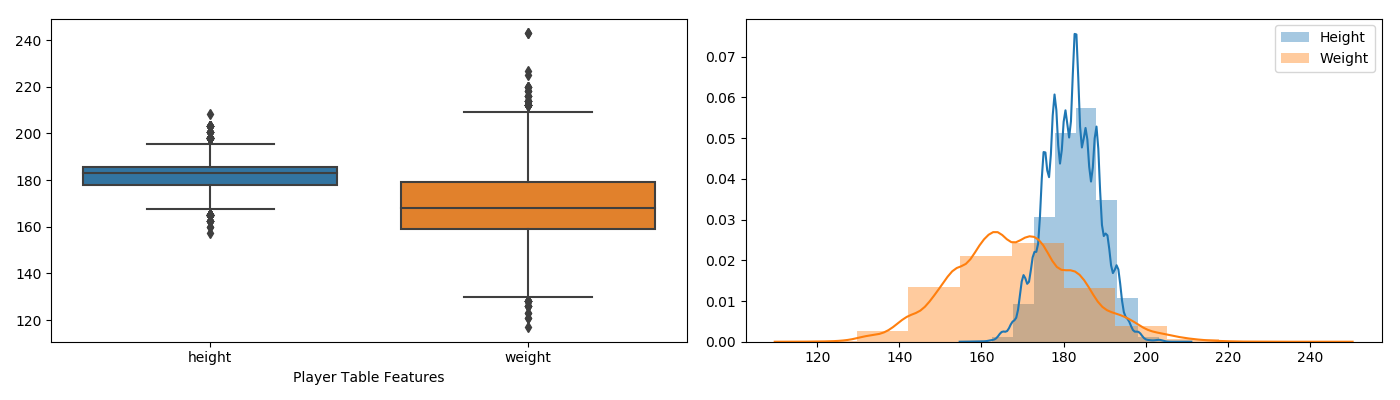

<IPython.core.display.Javascript object>


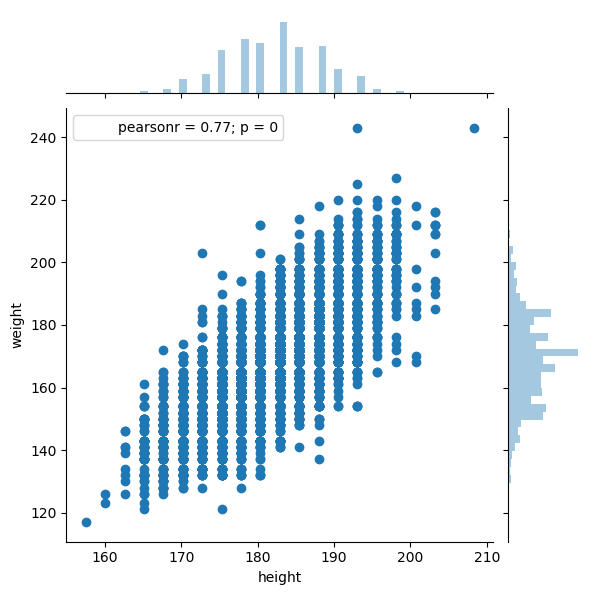

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots(nrows = 1, ncols = 2)
fig1.set_size_inches(14,4)
sns.boxplot(data = df_player.loc[:,["height",'weight']], ax = ax1[0])
ax1[0].set_xlabel('Player Table Features')
ax1[0].set_ylabel('')

sns.distplot(a = df_player.loc[:,["height"]], bins= 10, kde = True, ax = ax1[1], \
            label = 'Height')
sns.distplot(a = df_player.loc[:,["weight"]], bins= 10, kde = True, ax = ax1[1], \
            label = 'Weight')

ax1[1].legend()
sns.jointplot(x='height',y = 'weight',data = df_player,kind = 'scatter')
fig1.tight_layout()

<IPython.core.display.Javascript object>


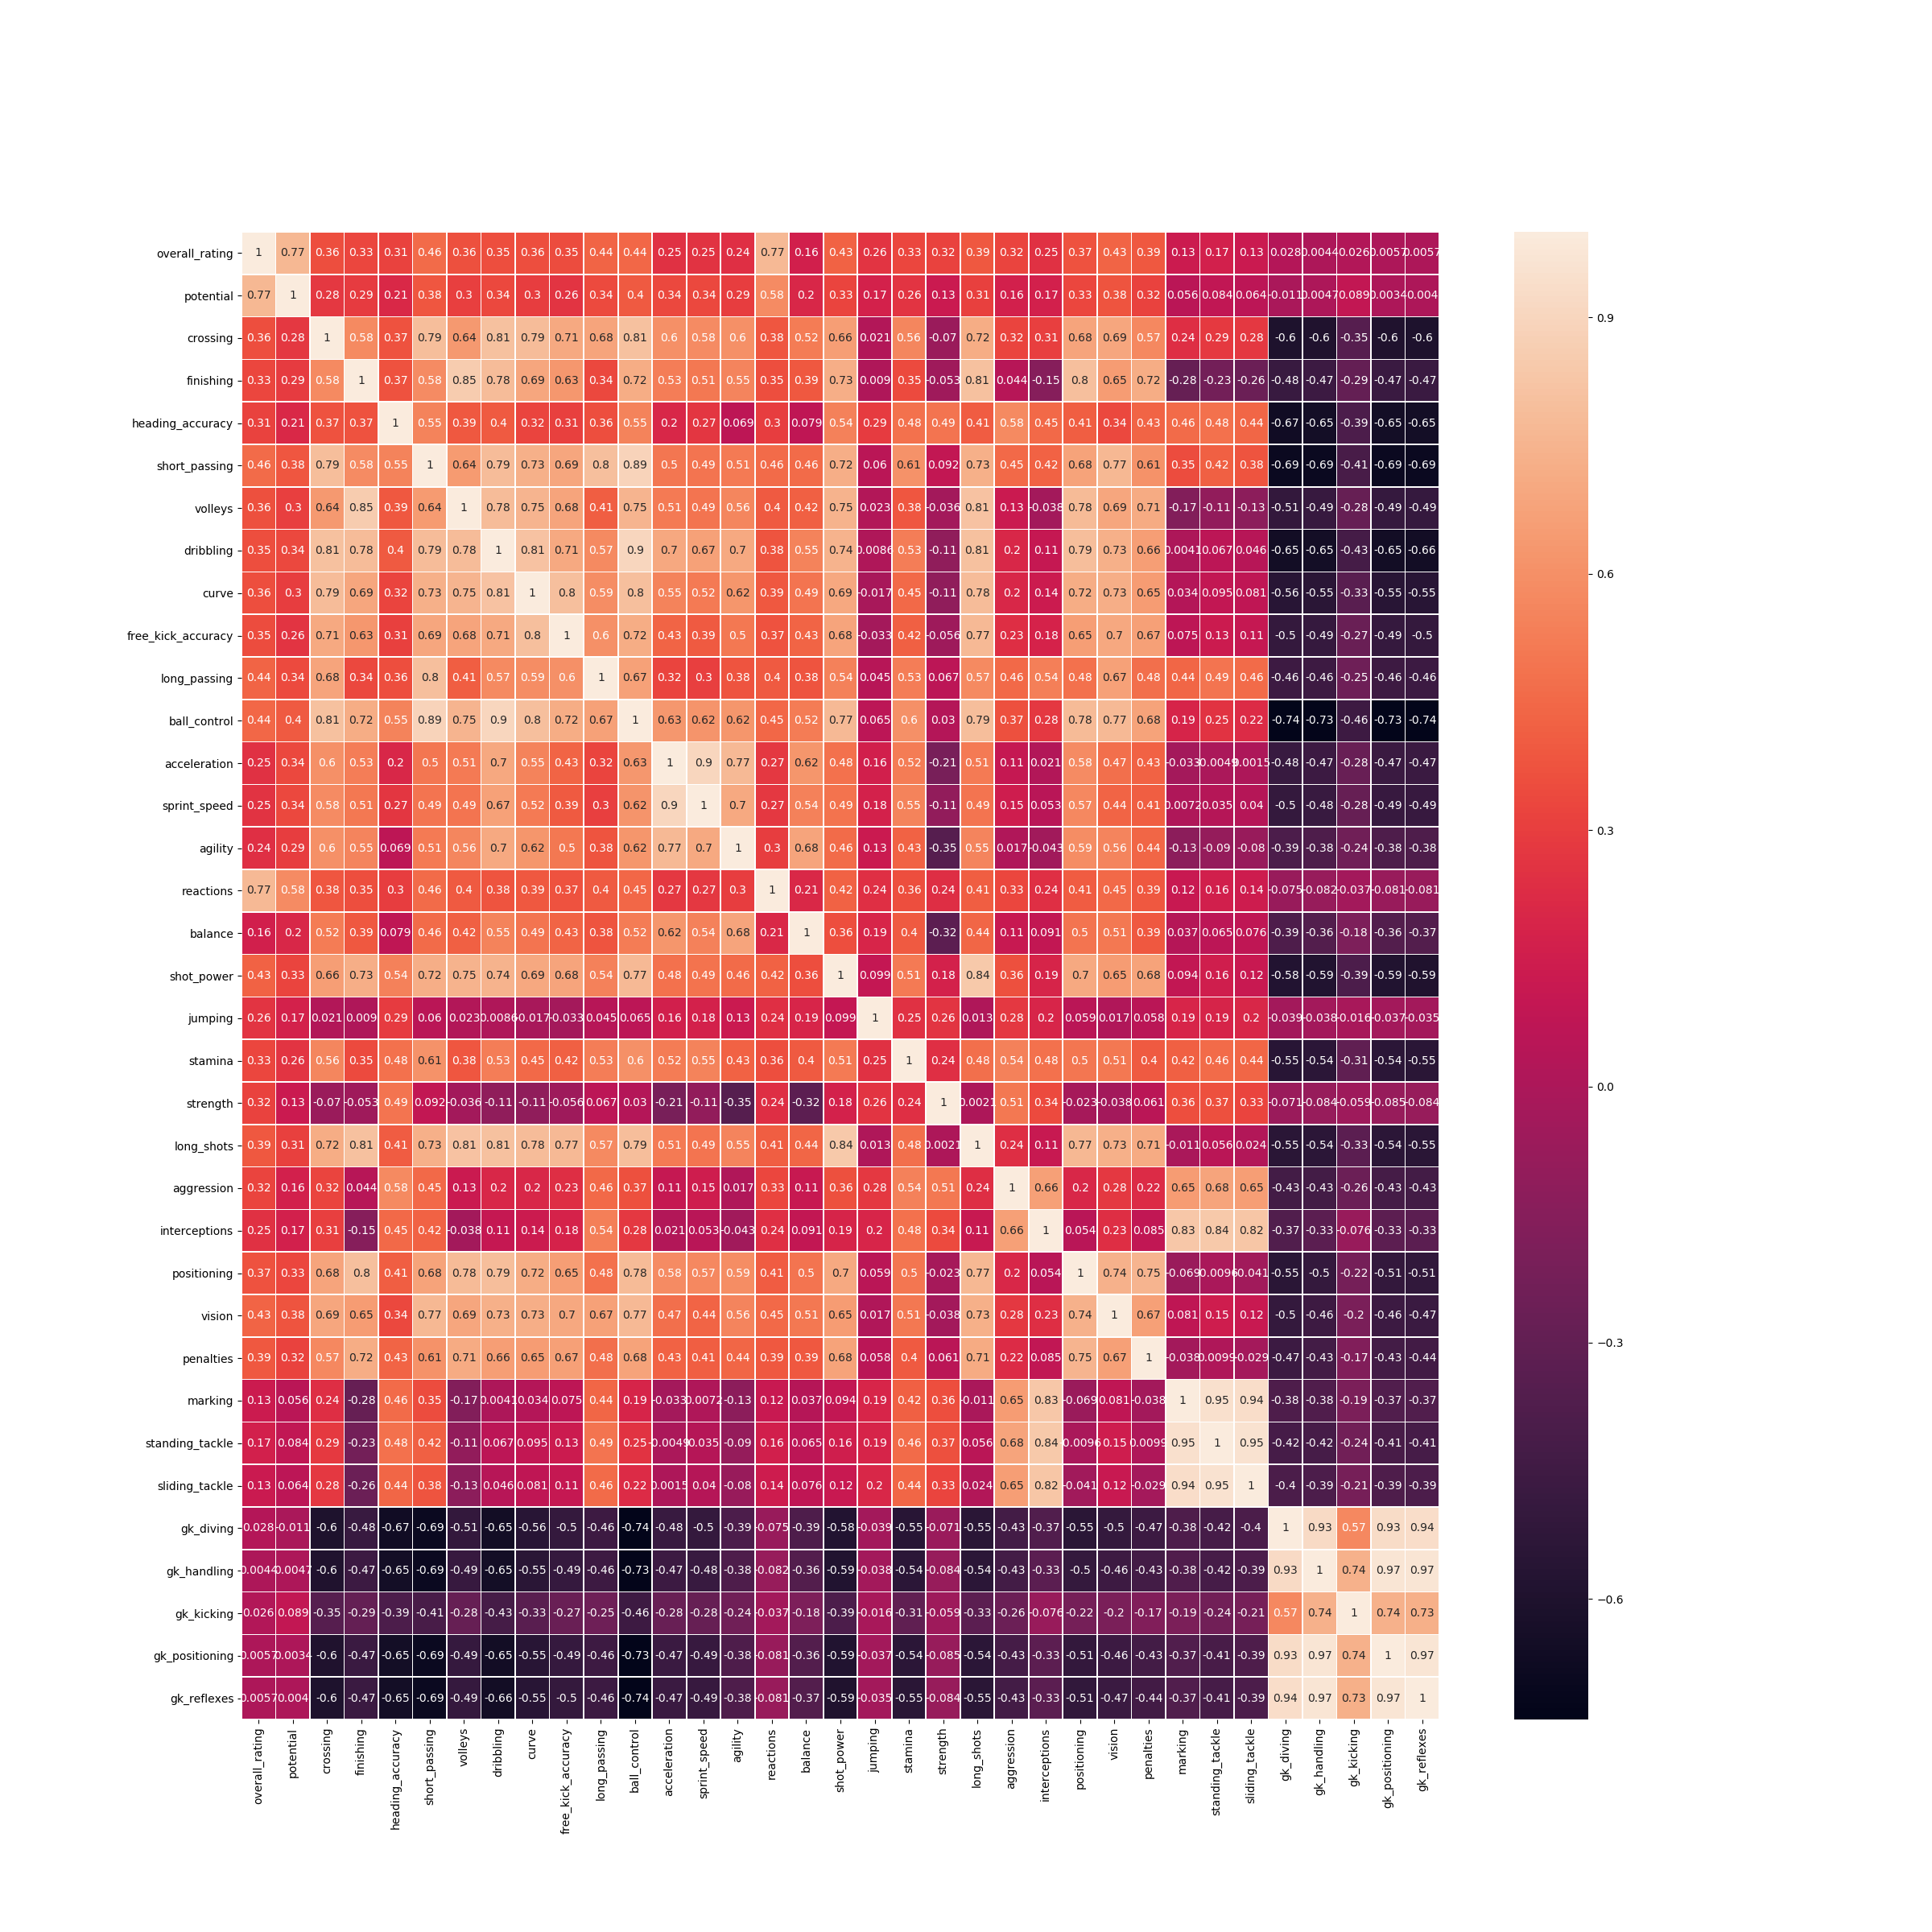

In [17]:
fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr2,annot = True,linewidths=0.5,ax = ax2)

<IPython.core.display.Javascript object>


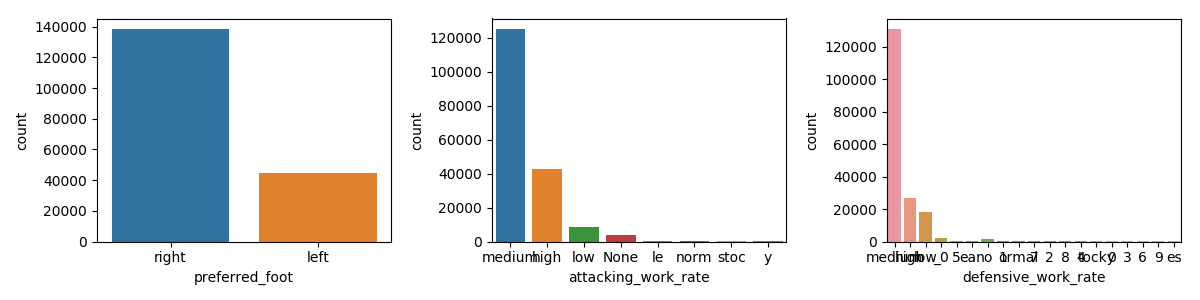

In [18]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 3)
fig3.set_size_inches(12,3)
sns.countplot(x = df_player_att['preferred_foot'],ax = ax3[0])
sns.countplot(x = df_player_att['attacking_work_rate'],ax = ax3[1])
sns.countplot(x = df_player_att['defensive_work_rate'],ax = ax3[2])
fig3.tight_layout()

<IPython.core.display.Javascript object>


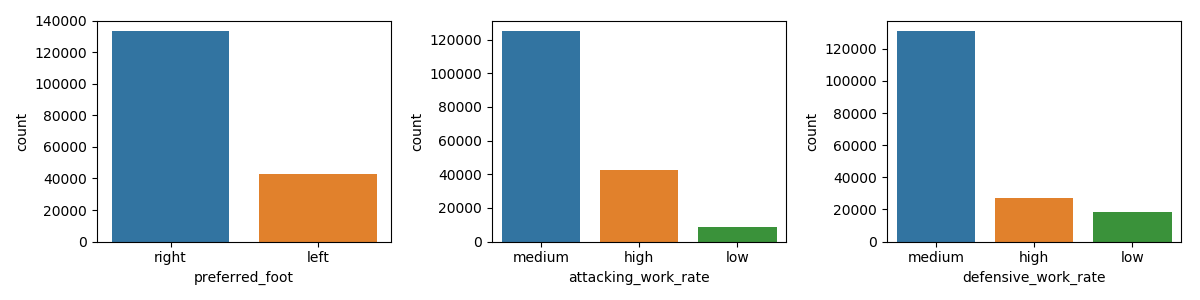

In [19]:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 3)
fig4.set_size_inches(12,3)
sns.countplot(x = df_player_att_updated1['preferred_foot'],ax = ax4[0])
sns.countplot(x = df_player_att_updated1['attacking_work_rate'],ax = ax4[1])
sns.countplot(x = df_player_att_updated1['defensive_work_rate'],ax = ax4[2])
fig4.tight_layout()

<IPython.core.display.Javascript object>


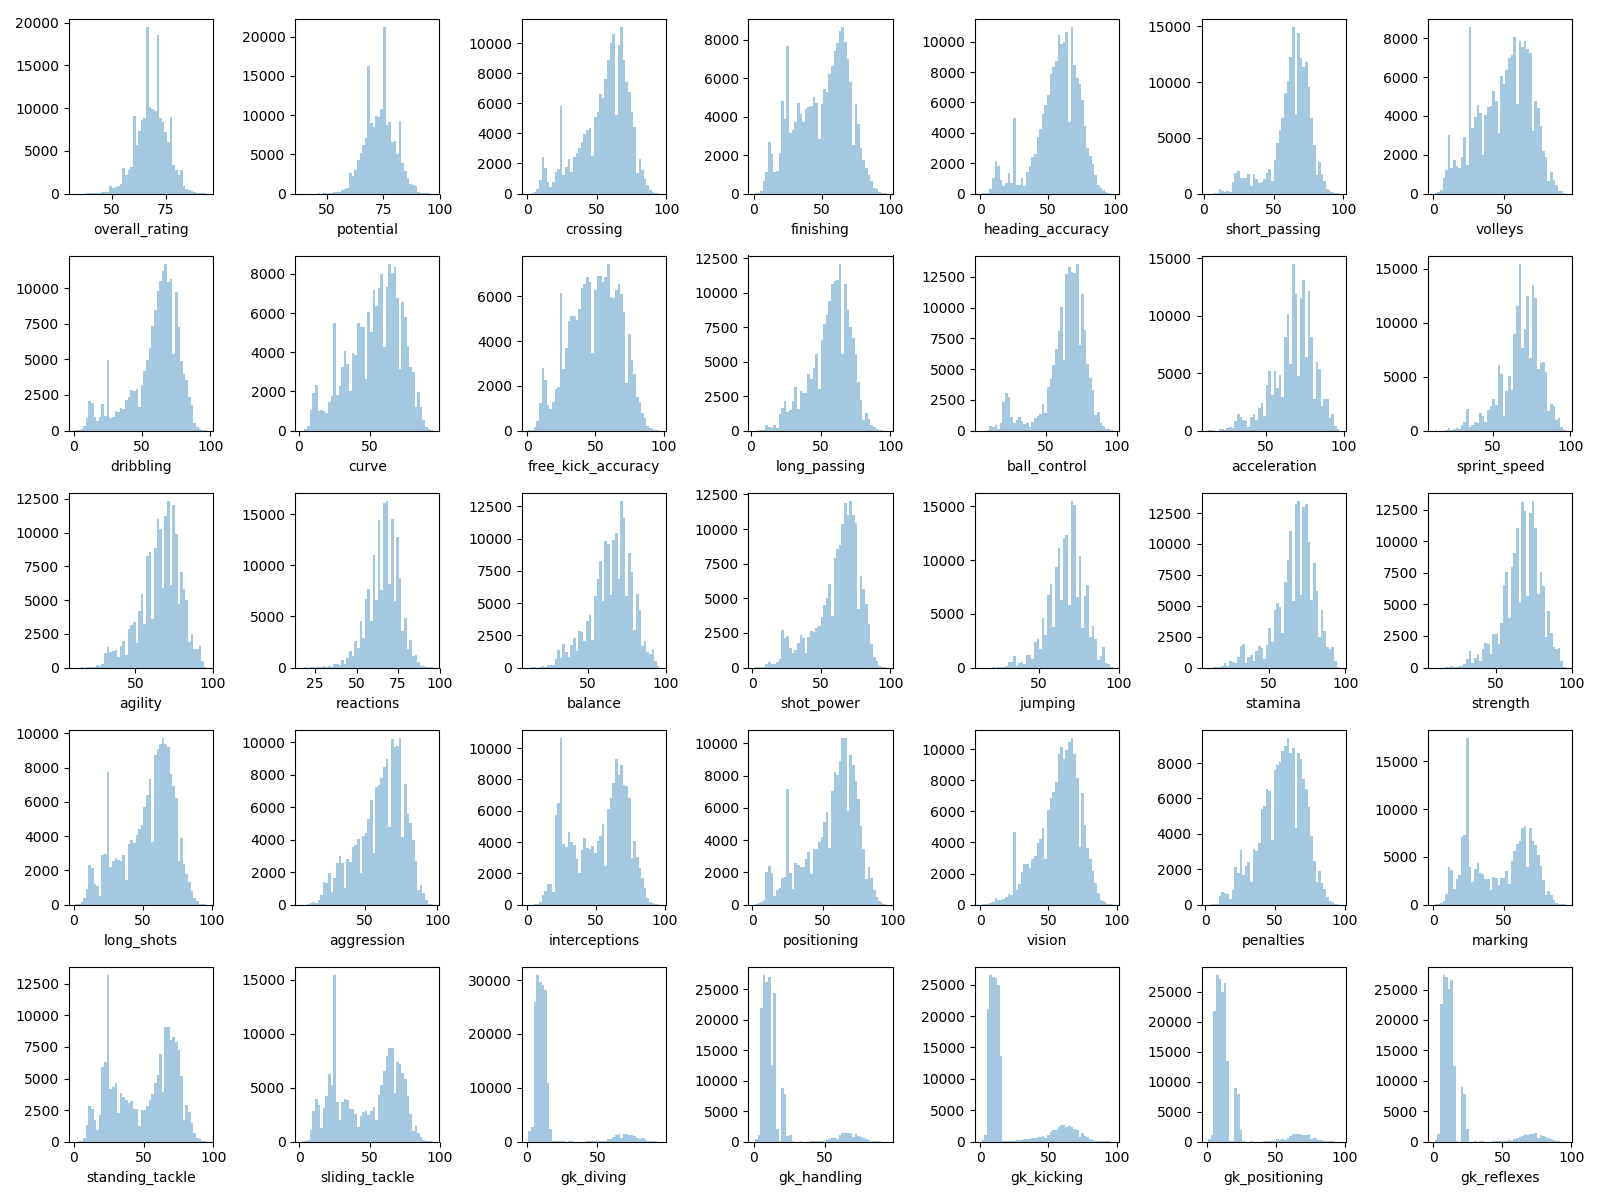

In [20]:
pat = df_player_att_updated1.loc[:,df_player_att_updated1.columns.tolist()[3:]]
fig5, ax5 = plt.subplots(nrows=5,ncols=7)

fig5.set_size_inches(16,12)

for i,j in enumerate(df_player_att_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.distplot(pat.loc[:,j],kde = False,hist = True, ax = ax5[int(i/7)][i%7])

fig5.tight_layout()

<IPython.core.display.Javascript object>


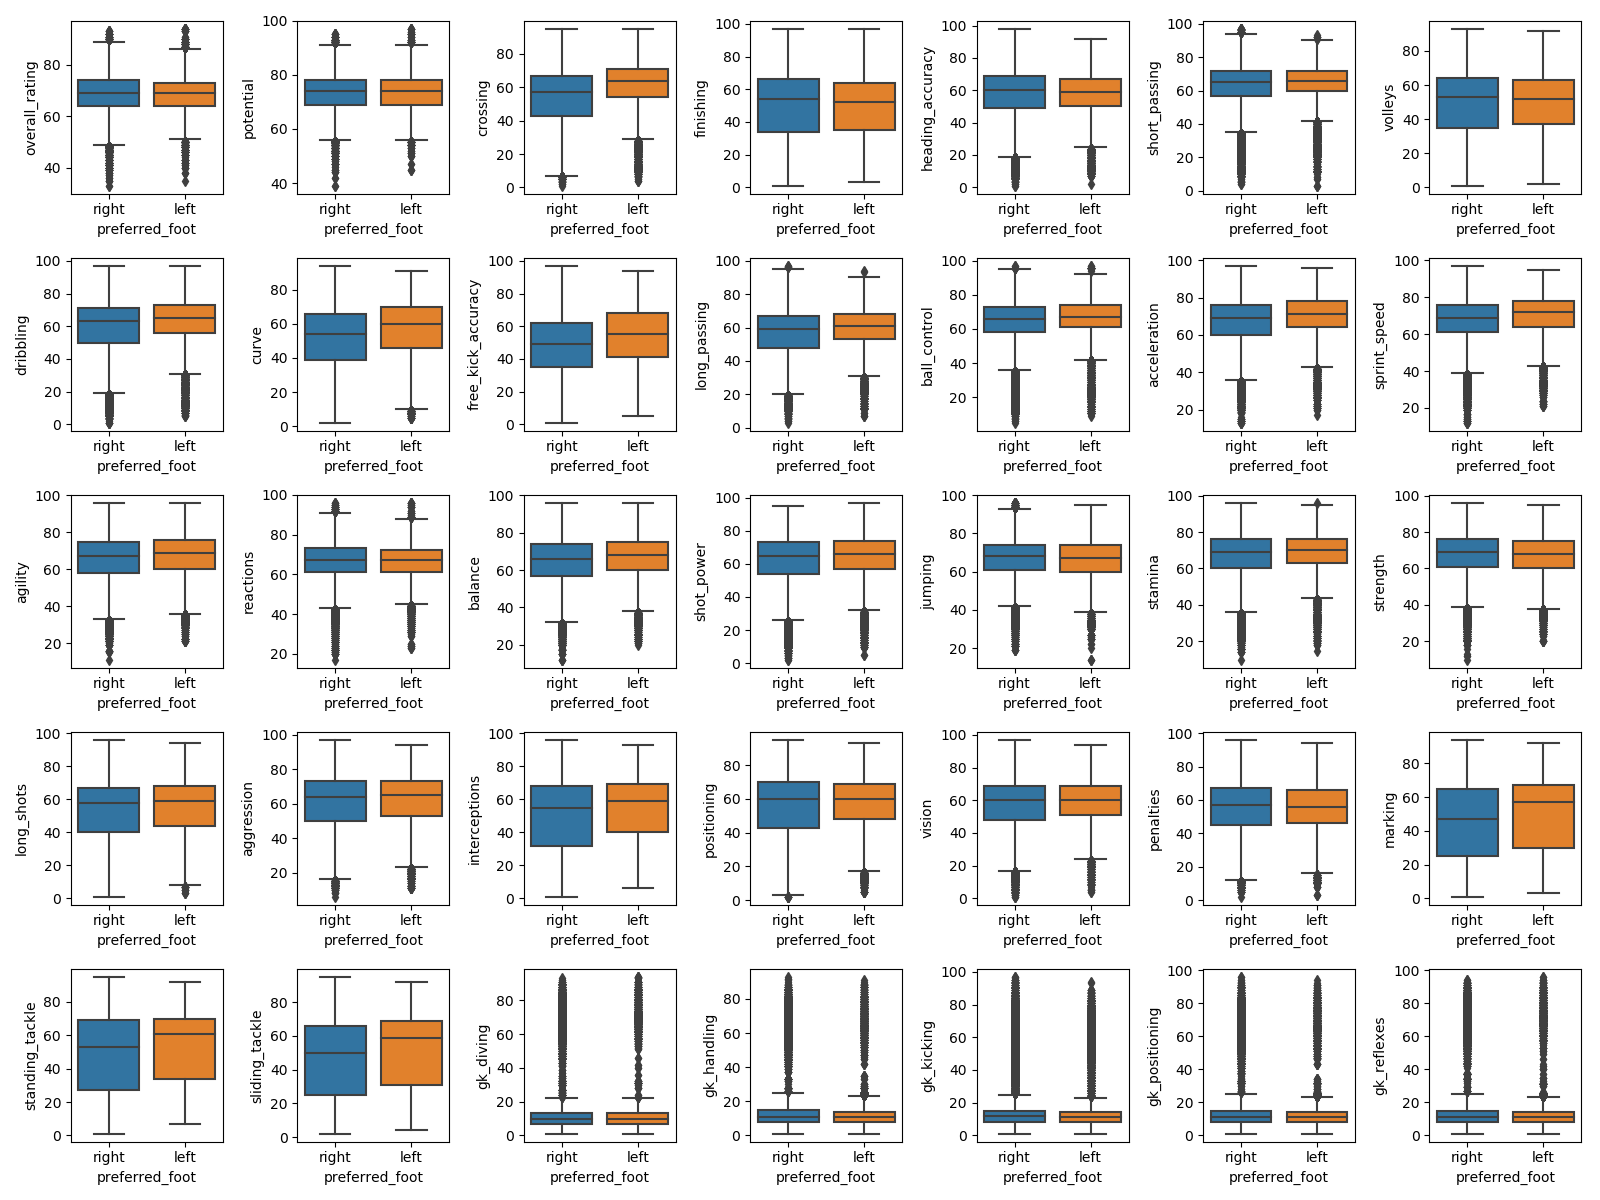

In [21]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)

fig6.set_size_inches(16,12)

for i,j in enumerate(df_player_att_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "preferred_foot", y = j, data= pat, ax = ax6[int(i/7)][i%7])

fig6.tight_layout()

<IPython.core.display.Javascript object>


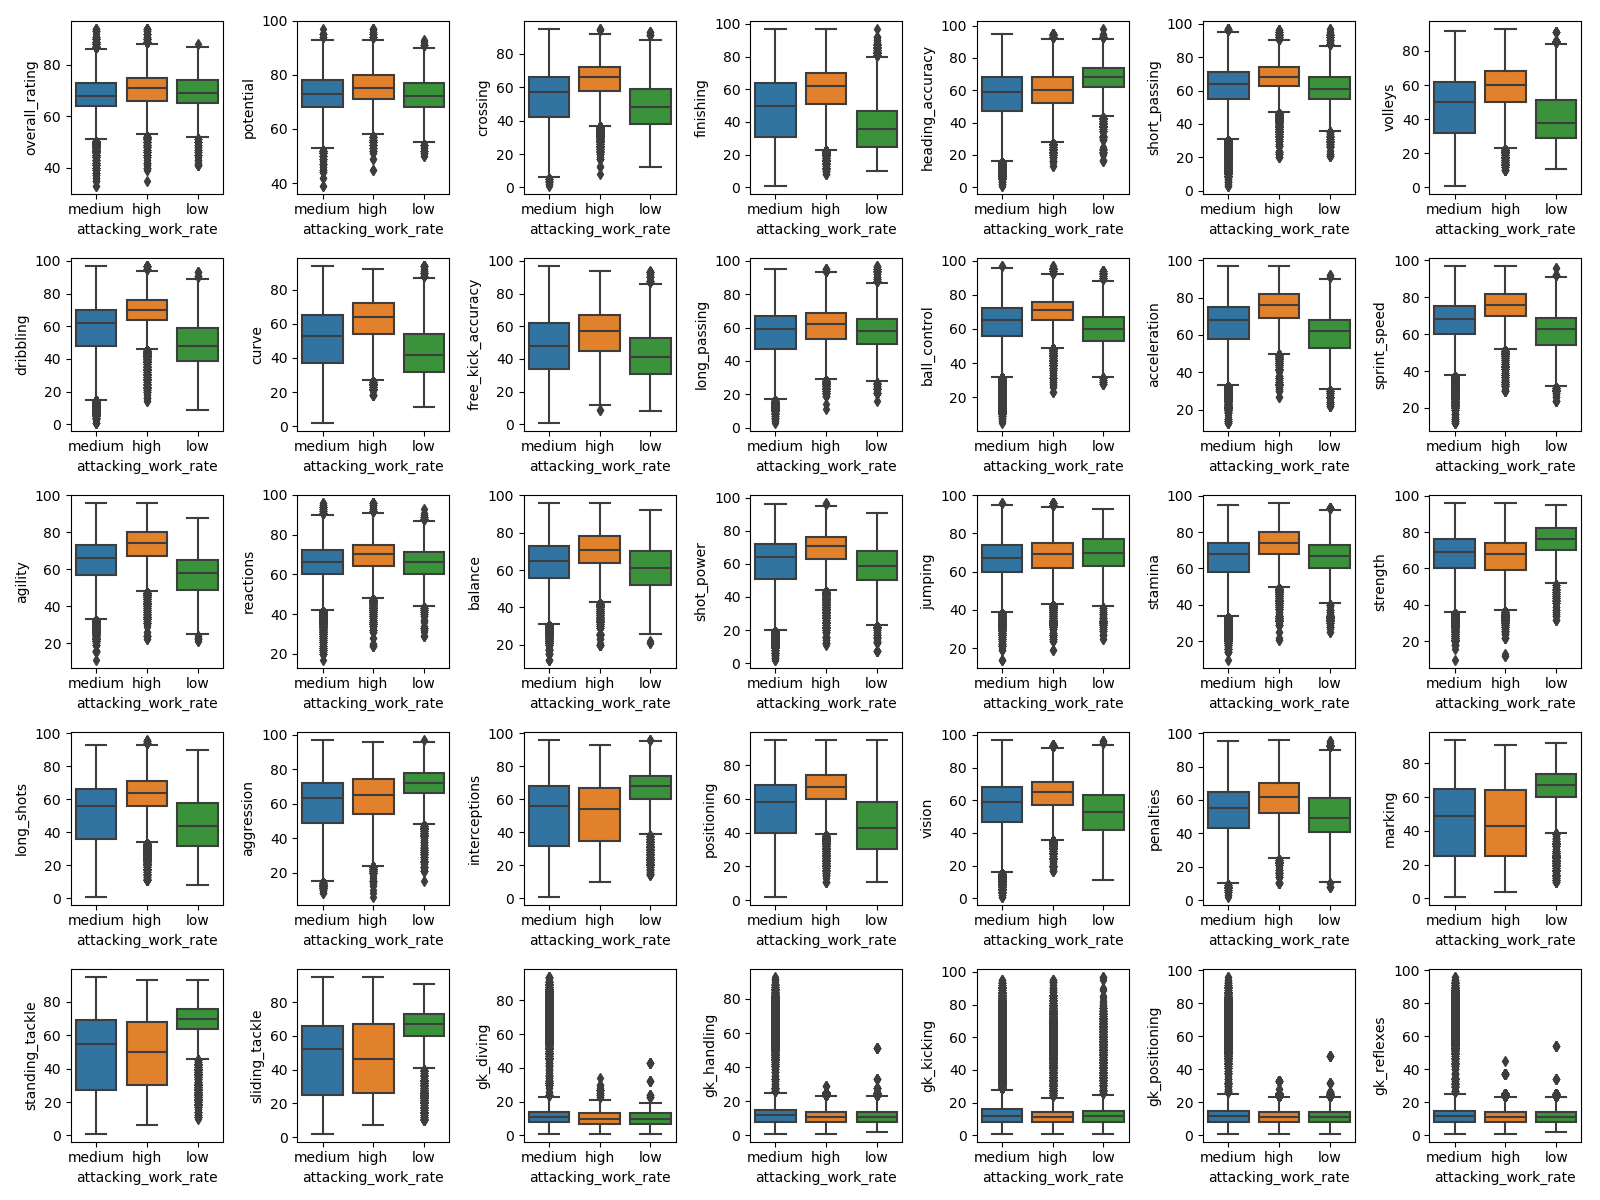

In [22]:
fig7, ax7 = plt.subplots(nrows=5,ncols=7)

fig7.set_size_inches(16,12)
for i,j in enumerate(df_player_att_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "attacking_work_rate", y = j, data= pat, ax = ax7[int(i/7)][i%7])

fig7.tight_layout()

<IPython.core.display.Javascript object>


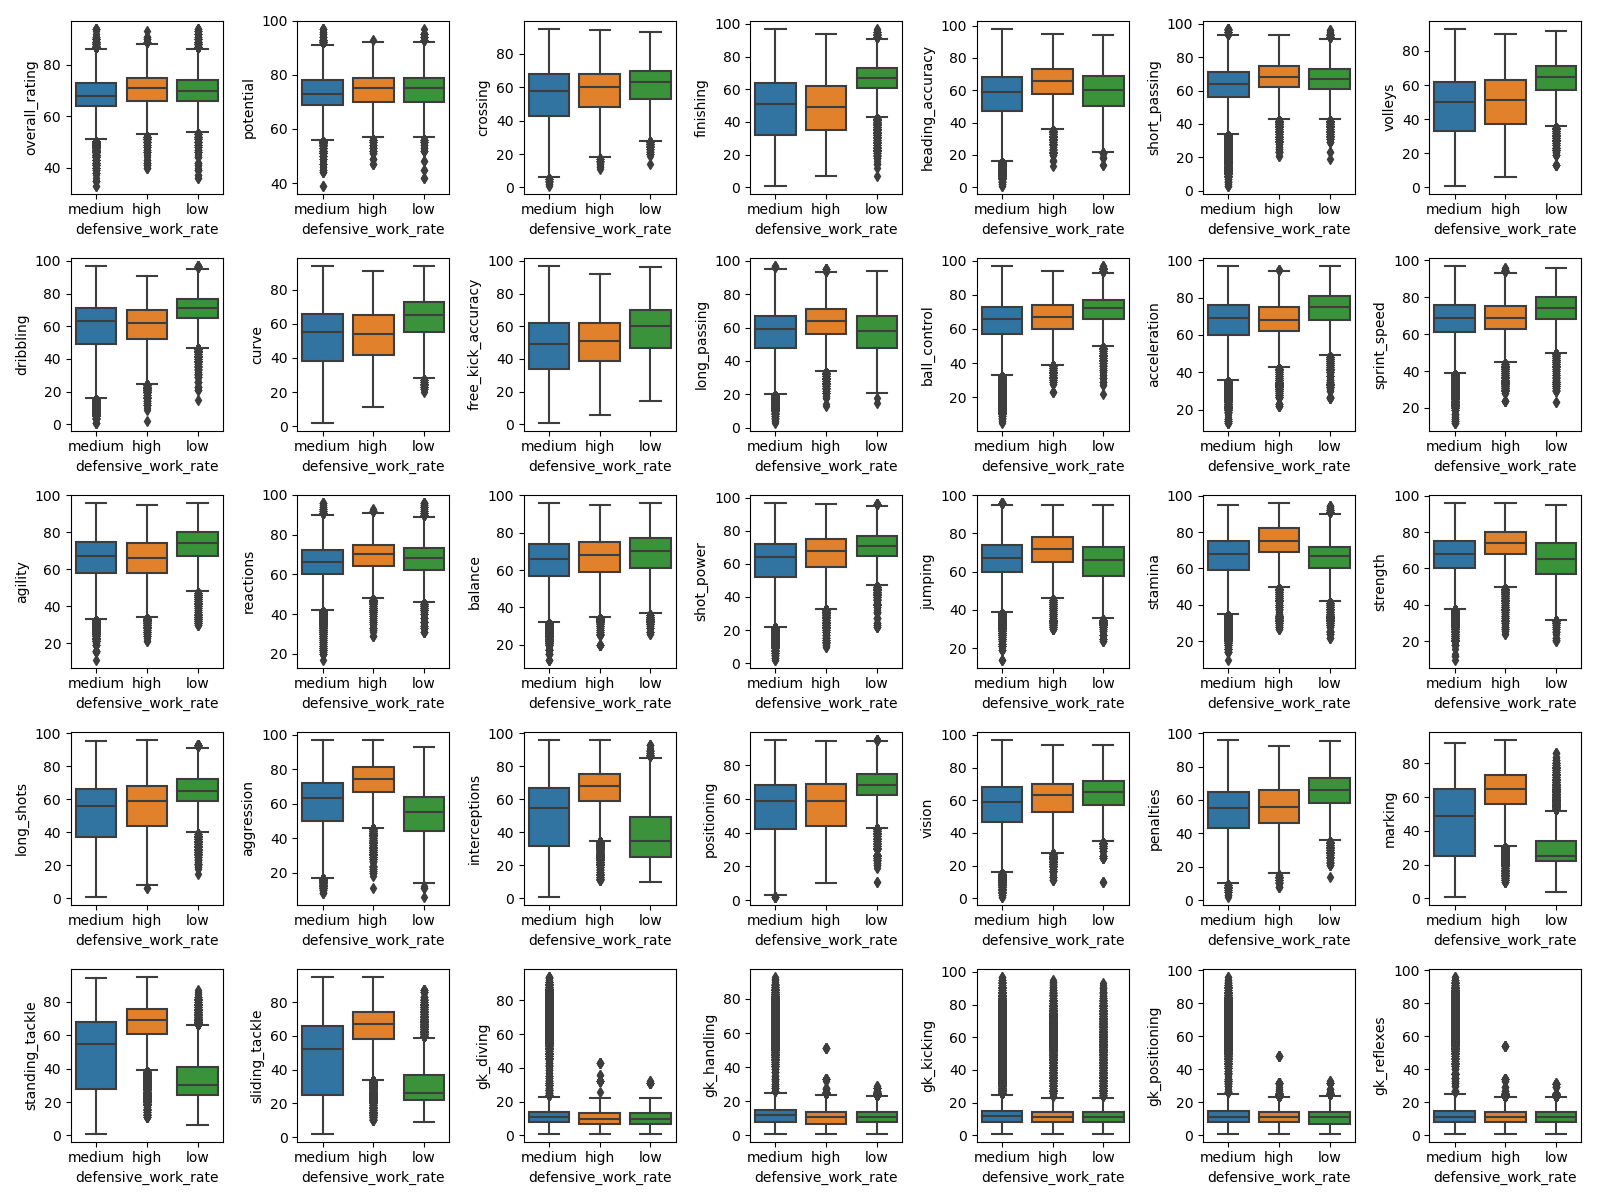

<IPython.core.display.Javascript object>


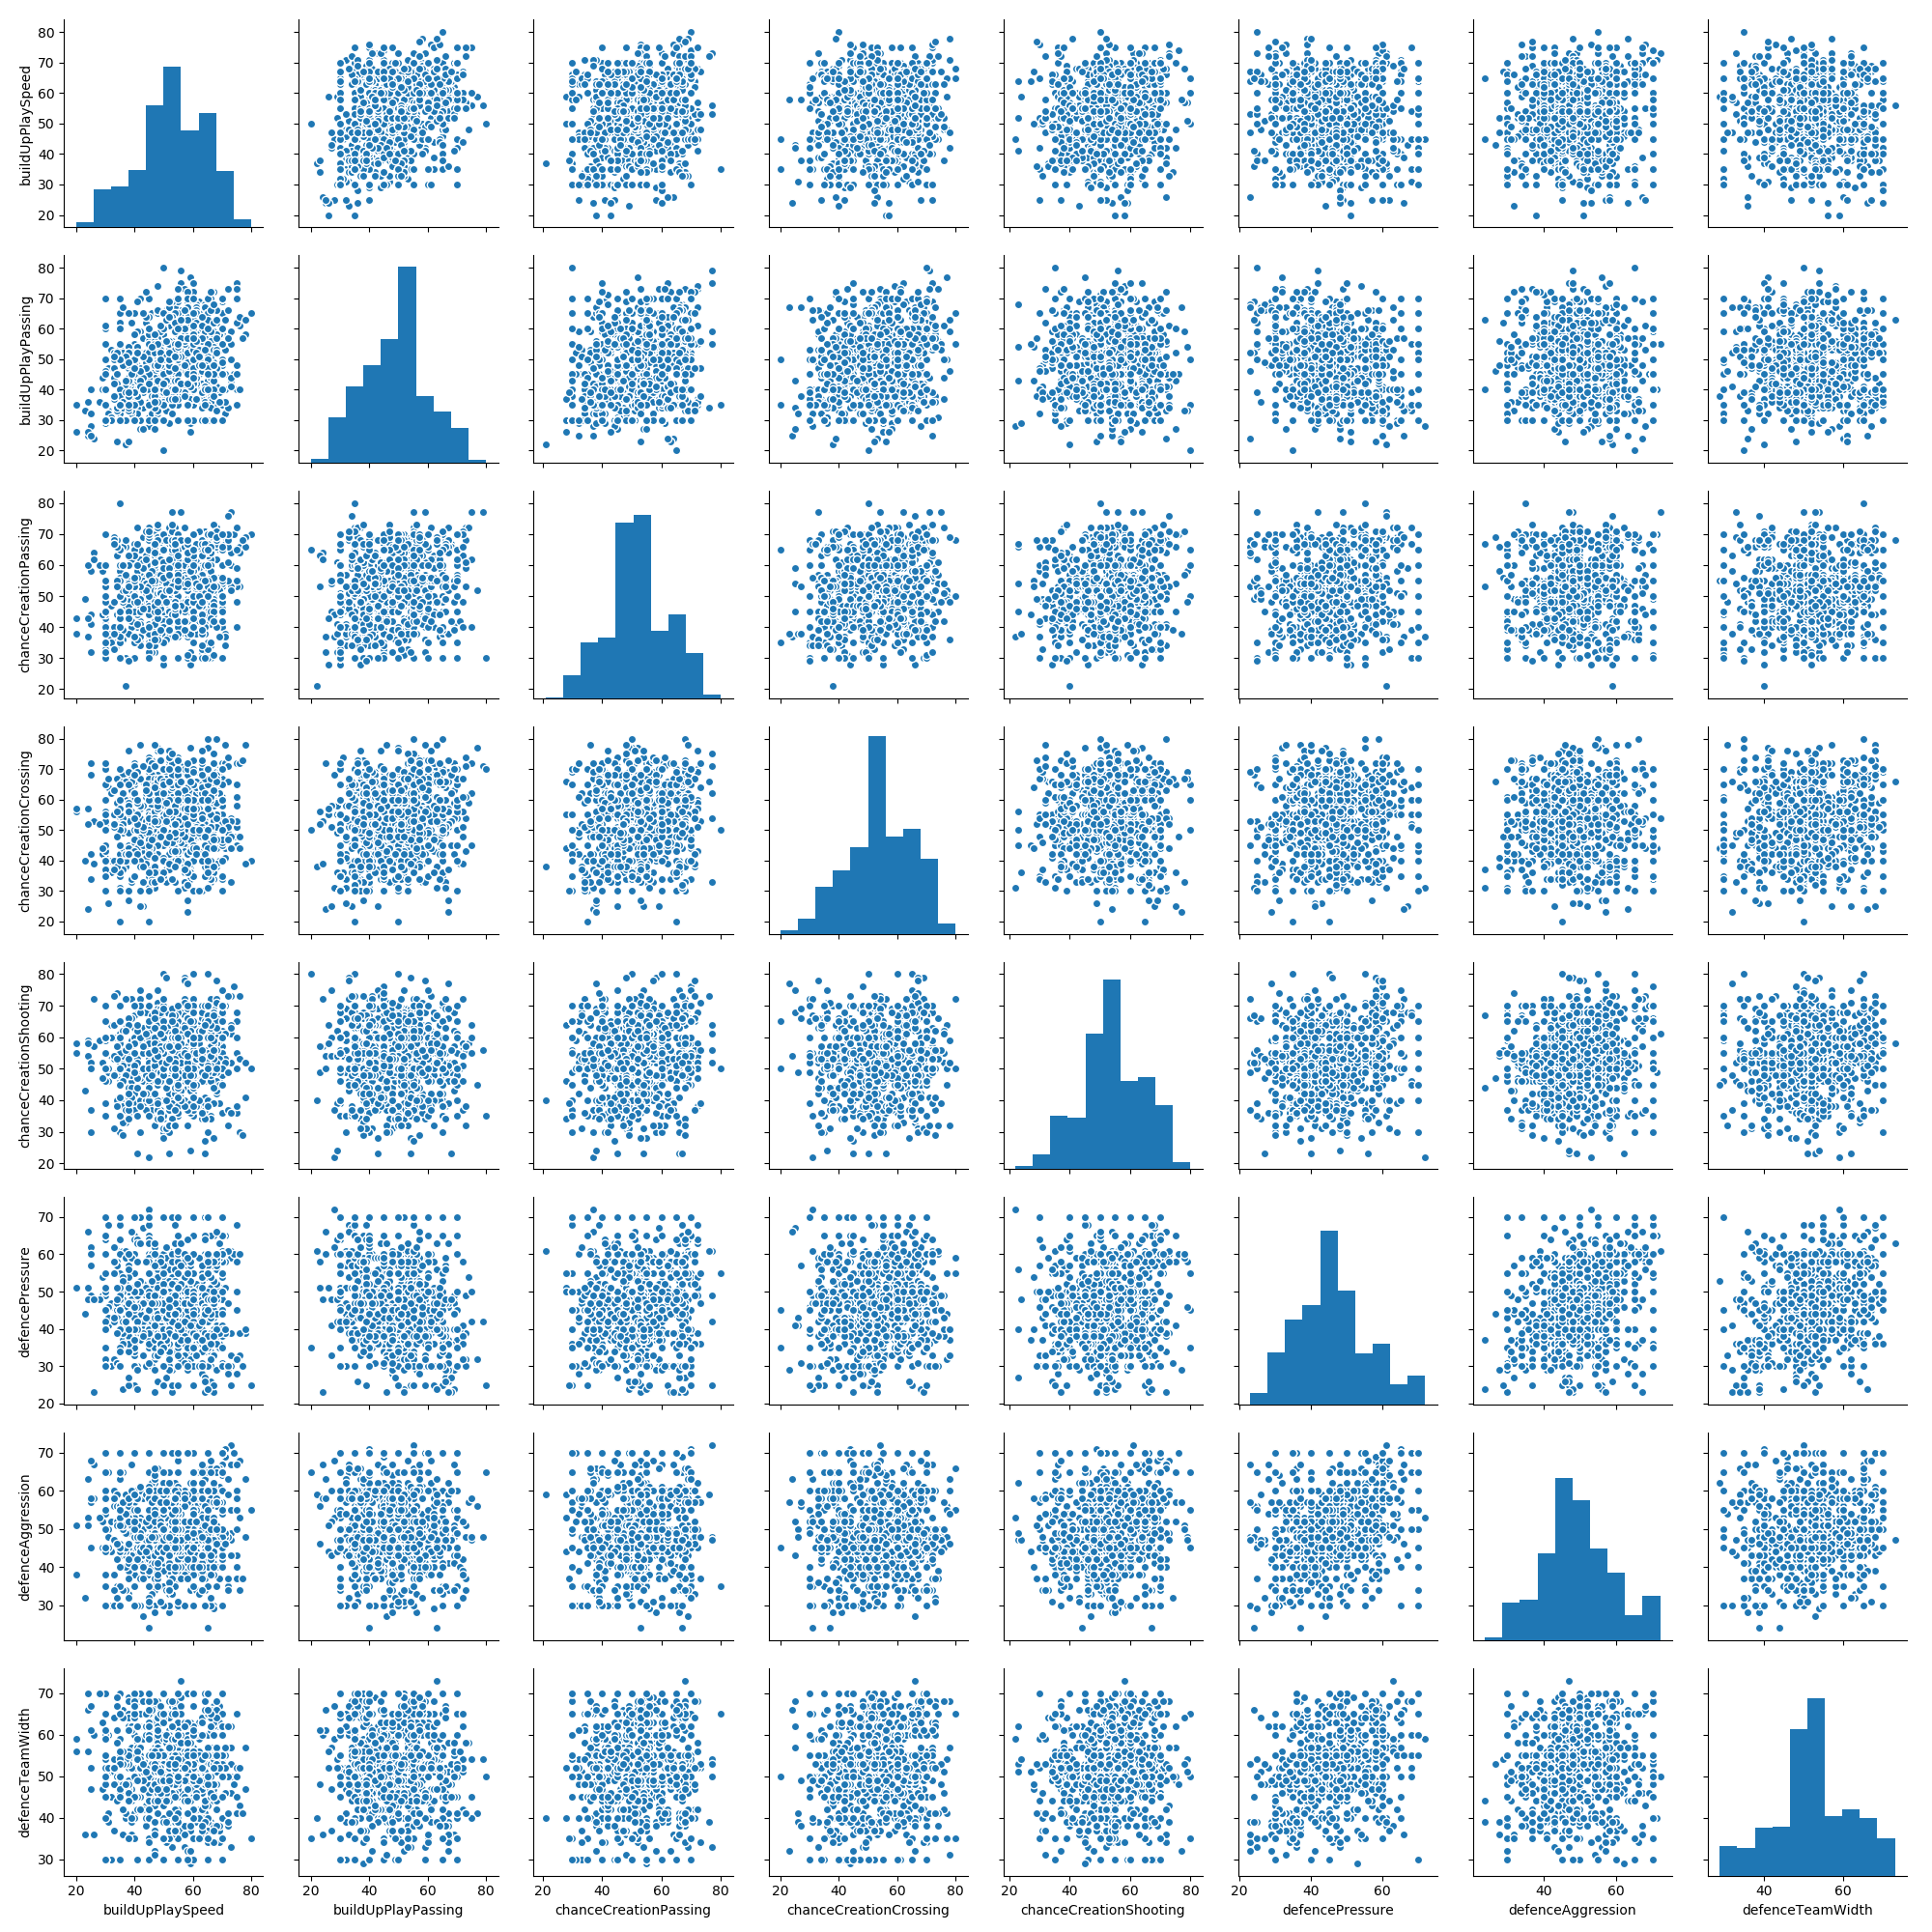

In [23]:
fig8, ax8 = plt.subplots(nrows=5,ncols=7)

fig8.set_size_inches(16,12)

for i,j in enumerate(df_player_att_updated1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "defensive_work_rate", y = j, data= pat, ax = ax8[int(i/7)][i%7])
fig8.tight_layout()

# Team Attribute Table - Correlation of continuous features
sns.pairplot(tat)

<IPython.core.display.Javascript object>


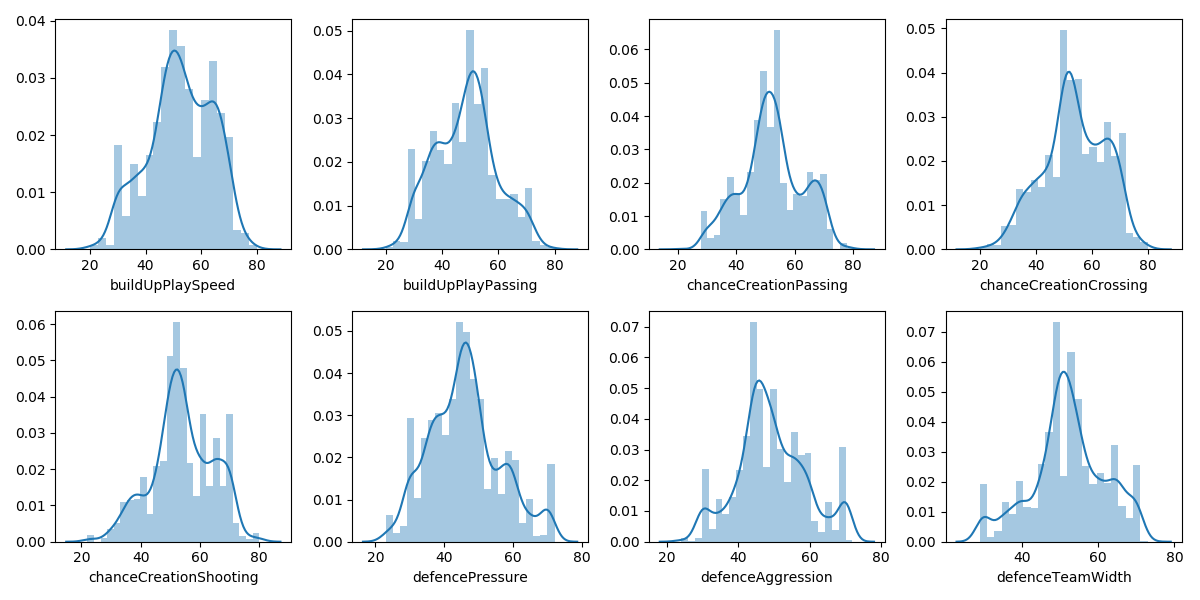

id  team_fifa_api_id  team_api_id  buildUpPlaySpeed  buildUpPlayPassing  \
0   1               434         9930                60                  50   
1   2               434         9930                52                  56   
2   3               434         9930                47                  54   
3   4                77         8485                70                  70   
4   5                77         8485                47                  52   

   chanceCreationPassing  chanceCreationCrossing  chanceCreationShooting  \
0                     60                      65                      55   
1                     54                      63                      64   
2                     54                      63                      64   
3                     70                      70                      70   
4                     53                      48                      52   

   defencePressure  defenceAggression  defenceTeamWidth  
0               50                 55                45  
1               47                 44                54  
2               47                 44                54  
3               60                 70                70  
4               47                 47                52

In [24]:
fig9, ax9 = plt.subplots(nrows=2,ncols=4)

fig9.set_size_inches(12,6)
for i,j in enumerate(df_team_att_updated1.select_dtypes(include = ['int64']).columns[3:].tolist()):
    sns.distplot(tat.loc[:,j],kde =True,hist = True, ax = ax9[int(i/4)][i%4])
fig9.tight_layout()

df_team_att_updated1.select_dtypes(include = ['int64']).head()

In [25]:
tat.select_dtypes(include = ['int64']).columns.tolist()

['buildUpPlaySpeed',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth']

<IPython.core.display.Javascript object>


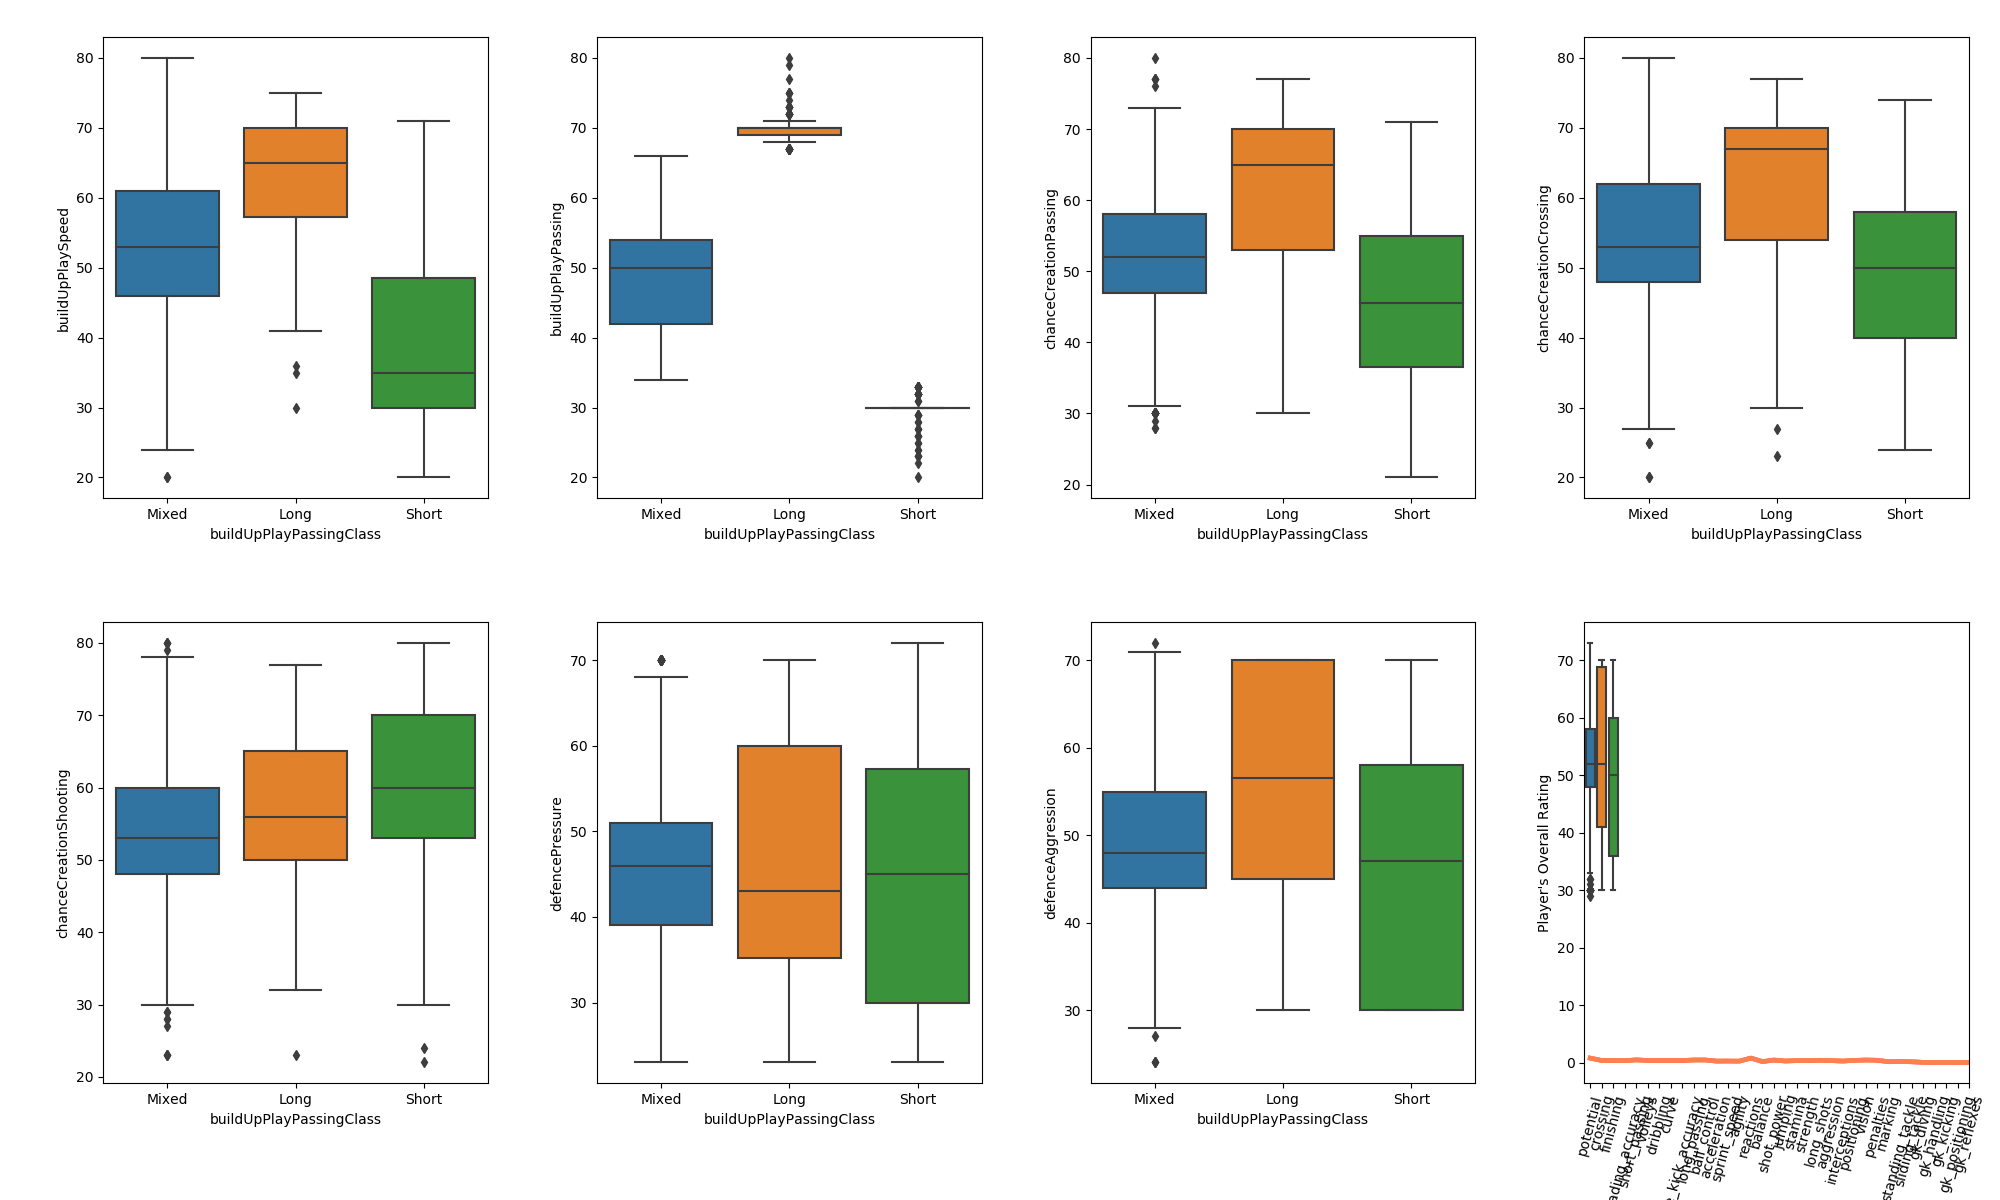

In [26]:
fig9, ax9 = plt.subplots(nrows=2,ncols=4)
fig9.set_size_inches(12,6)

for i,j in enumerate(df_team_att_updated1.select_dtypes(include = ['int64']).columns[3:].tolist()):
    sns.boxplot(data = tat, y = j, x = tat.select_dtypes(include = ['object']).columns[3],\
                                                      ax = ax9[int(i/4)][i%4])

fig9.tight_layout()

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from math import sqrt
import sys
from sklearn import preprocessing
from sklearn import tree
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

#from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import ShuffleSplit
from sklearn.svm import SVC
from time import time

import matplotlib.pyplot as plt

C:\Users\skhaldar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\skhaldar\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [28]:
print(df_player_att.columns)

print(df_player_att.describe().transpose())

#is any row NULL ?

print(df_player_att.isnull().any().any(), df_player_att.shape)

print(df_player_att.isnull().sum(axis=0))

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')
                       count           mean            std     min        25%  \
id                  183978.0   91989.500000   53110.018250     1.0   45995.25   
player_fifa_api_id  183978.0  165671.524291   53851.094769     2.0  155798.00   
player_api_id       183978.0  135900.617324  1

In [29]:
rows = df_player_att.shape[0]

# Drop the NULL rows

df_player_att = df_player_att.dropna()

#Check if all NULLS are gone ?

print(rows)

print(df_player_att.isnull().any().any(), df_player_att.shape)

#How many rows with NULL values?

print(rows - df_player_att.shape[0])

#Shuffle the rows of df so we get a distributed sample when we display top few rows

df_player_att = df_player_att.reindex(np.random.permutation(df_player_att.index))

183978
False (180354, 42)
3624


In [30]:
potentialFeatures = ['acceleration', 'curve', 'free_kick_accuracy', 'ball_control', 'shot_power', 'stamina']

#prints out the correlation coefficient of “overall_rating” of a player with each feature we added to the list as potential

# check how the features are correlated with the overall ratings

for f in potentialFeatures:

    related = df_player_att['overall_rating'].corr(df_player_att[f])

    print("%s: %f" % (f,related))

#selecting the columns and creating a list with correlation coefficients, called “correlations”.

cols = ['potential',  'crossing', 'finishing', 'heading_accuracy',

       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',

       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',

       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',

       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',

       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',

       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',

       'gk_reflexes']

acceleration: 0.243998
curve: 0.357566
free_kick_accuracy: 0.349800
ball_control: 0.443991
shot_power: 0.428053
stamina: 0.325606


In [31]:
correlations = [ df_player_att['overall_rating'].corr(df_player_att[f]) for f in cols ]

In [32]:
def plot_dataframe(df_player_att, y_label):  
    color='coral'
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.ylabel(y_label)
    ax = df2.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(df2.index)
    ax.set_xticklabels(df2.attributes, rotation=75); #Notice the ; (remove it and see what happens !)

    plt.show()    

In [33]:
df2 = pd.DataFrame({'attributes': cols, 'correlation': correlations}) 

In [36]:
plot_dataframe(df2, 'Player\'s Overall Rating')
plt.show()

In [37]:
#--------------------------------------------------------------------------

# Part #2(b) - Player Attributes Table - Grouping Players/Kmeans Clustering

#-------------------------------------------------------------------------

# Define the features to use for grouping players

select5features = ['gk_kicking', 'potential', 'marking', 'interceptions', 'standing_tackle']

print(select5features)

# Generate a new dataframe by selecting the features you just defined

df_select = df_player_att[select5features].copy(deep=True)

print(df_select.head())



# KMeans to cluster the values (i.e., player features on gk_kicking, potential, marking, interceptions, and standing_tackle)

# Perform scaling on the dataframe containing the features

data = scale(df_select)

# Define number of clusters

noOfClusters = 4

# Train a model

model = KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20).fit(data)

print(90*'_')

print("\nCount of players in each cluster")

print(90*'_')

print(pd.value_counts(model.labels_, sort=False))

['gk_kicking', 'potential', 'marking', 'interceptions', 'standing_tackle']
        gk_kicking  potential  marking  interceptions  standing_tackle
67488         59.0       64.0     25.0           25.0             25.0
91456         14.0       78.0     57.0           62.0             68.0
136242        11.0       64.0     22.0           44.0             27.0
50035          9.0       77.0     68.0           74.0             74.0
123767        68.0       80.0     11.0           24.0             11.0
__________________________________________________________________________________________

Count of players in each cluster
__________________________________________________________________________________________
0    23786
1    50650
2    55863
3    50055
dtype: int64


In [38]:
Player_Attributes = pd.read_sql_query("SELECT * from Player_Attributes", cnx)

In [39]:
#select relevant fields

Player_Attributes.dropna(inplace=True)
Player_Attributes.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date'], axis = 1, inplace = True)
overall_rating = Player_Attributes['overall_rating']
features = Player_Attributes.drop('overall_rating', axis = 1)
features.head()

potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   finishing  heading_accuracy  short_passing  volleys  dribbling  \
0       44.0              71.0           61.0     44.0       51.0   
1       44.0              71.0           61.0     44.0       51.0   
2       44.0              71.0           61.0     44.0       51.0   
3       43.0              70.0           60.0     43.0       50.0   
4       43.0              70.0           60.0     43.0       50.0   

      ...       vision  penalties  marking  standing_tackle  sliding_tackle  \
0     ...         54.0       48.0     65.0             69.0            69.0   
1     ...         54.0       48.0     65.0             69.0            69.0   
2     ...         54.0       48.0     65.0             66.0            69.0   
3     ...         53.0       47.0     62.0             63.0            66.0   
4     ...         53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 37 columns]

In [40]:
# Use LabelEncoder to convert categorical data field into numerical data field

le_sex = preprocessing.LabelEncoder()

#to convert into numbers

features.preferred_foot = le_sex.fit_transform(features.preferred_foot)
features.attacking_work_rate = le_sex.fit_transform(features.attacking_work_rate)
features.defensive_work_rate = le_sex.fit_transform(features.defensive_work_rate)
features.head()


potential  preferred_foot  attacking_work_rate  defensive_work_rate  \
0       71.0               1                    4                   14   
1       71.0               1                    4                   14   
2       66.0               1                    4                   14   
3       65.0               1                    4                   14   
4       65.0               1                    4                   14   

   crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  \
0      49.0       44.0              71.0           61.0     44.0       51.0   
1      49.0       44.0              71.0           61.0     44.0       51.0   
2      49.0       44.0              71.0           61.0     44.0       51.0   
3      48.0       43.0              70.0           60.0     43.0       50.0   
4      48.0       43.0              70.0           60.0     43.0       50.0   

      ...       vision  penalties  marking  standing_tackle  sliding_tackle  \
0     ...         54.0       48.0     65.0             69.0            69.0   
1     ...         54.0       48.0     65.0             69.0            69.0   
2     ...         54.0       48.0     65.0             66.0            69.0   
3     ...         53.0       47.0     62.0             63.0            66.0   
4     ...         53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 37 columns]

In [41]:
# Use pandas get_dummies to convert categorical value into numerical

features = pd.get_dummies(features)

# Feature scaling using MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
scaled_features = min_max_scaler.fit_transform(features)

pca = PCA(n_components = 6)
pca_features = pca.fit_transform(scaled_features)

# Train and predict model on Decision tree and on SGD regressor

reg1 = tree.DecisionTreeClassifier()

reg2 = linear_model.SGDRegressor()

reg3 = SVC(kernel='linear', C = 1.0)

In [42]:
#regs = {reg1:"Decision Tree", reg2:"SGDRegressor", reg3:"SVC"}

regs = {reg1:"Decision Tree", reg2:"SGDRegressor"}

for key in regs:
    t0 = time()
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, overall_rating, test_size=0.25, random_state=0)

    print ("--------------------")

    print (regs[key])

    print ("--------------------")

    t1 = time()

    key.fit(X_train, y_train)

    print ("Time taken to train the model: {}".format(time()-t1))

    t2 = time()

    pred_test = key.predict(X_test)

    pred_train = key.predict(X_train)

    print ("Time taken to predict the model: {}".format(time()-t2))

    t3 = time()

    print ("r2 score of this model on testing set is: {}".format(r2_score(y_test, pred_test)))

    print ("r2 score of this model on training set is: {}".format(r2_score(y_train, pred_train)))

--------------------
Decision Tree
--------------------
Time taken to train the model: 5.40255331993103
Time taken to predict the model: 0.17187762260437012
r2 score of this model on testing set is: 0.9508781775321792
r2 score of this model on training set is: 0.9988644730721816
--------------------
SGDRegressor
--------------------


C:\Users\skhaldar\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Time taken to train the model: 0.38335347175598145
Time taken to predict the model: 0.015613555908203125
r2 score of this model on testing set is: 0.8369844640948354
r2 score of this model on training set is: 0.8385644119973424


In [45]:
def fit_model(X, y):

    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    # Create cross-validation sets from the training data

    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object

    regressor1 = DecisionTreeRegressor()

    regressor2 = linear_model.SGDRegressor()

    #regressor3 = SVC()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10

    tree_params = {'max_depth' : [3, 6, 9, 20, 100], 'min_samples_split':[2, 3, 4, 5]}

    sgd_params = {'loss':['squared_loss', 'huber'], 'penalty': ['none', 'l2', 'l1', 'elasticnet'], 'n_iter':[10, 75, 100, 500]}

    # svm_params = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
 
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 

    scoring_fnc = make_scorer(performance_metric)

    # Updated cv_sets and scoring parameter

    grid = GridSearchCV(regressor1, tree_params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model

    #print("grid fit")

    grid = grid.fit(X, y)

    # Updated cv_sets and scoring parameter

    #grid = GridSearchCV(regressor2, sgd_params, scoring = scoring_fnc, cv = cv_sets)


    # Fit the grid search object to the data to compute the optimal model

    #grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [46]:
def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

In [47]:
print("Script Start")

t0 = time()

grid_reg = fit_model(pca_features, overall_rating)

print (grid_reg.score)

# grid_pred = grid_reg()

print ("Time taken to train and predict using GridSearch: {}".format(time() - t0))

print ("Best parameters are: {}".format(grid_reg.get_params()))

Script Start
<bound method RegressorMixin.score of DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>
Time taken to train and predict using GridSearch: 217.37774109840393
Best parameters are: {'criterion': 'mse', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


# Alternatively - 1

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Create your connection.
conn = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [51]:
df.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

      ...       vision  penalties  marking  standing_tackle  sliding_tackle  \
0     ...         54.0       48.0     65.0             69.0            69.0   
1     ...         54.0       48.0     65.0             69.0            69.0   
2     ...         54.0       48.0     65.0             66.0            69.0   
3     ...         53.0       47.0     62.0             63.0            66.0   
4     ...         53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

In [52]:
df.shape

(183978, 42)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [54]:
df = df.dropna()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 42 columns):
id                     180354 non-null int64
player_fifa_api_id     180354 non-null int64
player_api_id          180354 non-null int64
date                   180354 non-null object
overall_rating         180354 non-null float64
potential              180354 non-null float64
preferred_foot         180354 non-null object
attacking_work_rate    180354 non-null object
defensive_work_rate    180354 non-null object
crossing               180354 non-null float64
finishing              180354 non-null float64
heading_accuracy       180354 non-null float64
short_passing          180354 non-null float64
volleys                180354 non-null float64
dribbling              180354 non-null float64
curve                  180354 non-null float64
free_kick_accuracy     180354 non-null float64
long_passing           180354 non-null float64
ball_control           180354 non-null float64
accele

# Feature Selection

Given that we have about 35-40 different features to play around with, we can attempt to run some feature selection algorithms to reduce the size of our featureset

In [57]:
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE

In [58]:
df_new = df.copy()

We see that most of our data are numeric, but there are a few objects and floating data types. In the subsequent prediction analysis we’ll only concern ourself with the integer numerics, but there is obviously potential gains to be made by incorporating the qualitative data (i.e. player position).

In [59]:
df_new = df_new.select_dtypes(["int64","float64"])

In [49]:
dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)

In [61]:
df_new.shape

(180354, 38)

In [62]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 38 columns):
id                    180354 non-null int64
player_fifa_api_id    180354 non-null int64
player_api_id         180354 non-null int64
overall_rating        180354 non-null float64
potential             180354 non-null float64
crossing              180354 non-null float64
finishing             180354 non-null float64
heading_accuracy      180354 non-null float64
short_passing         180354 non-null float64
volleys               180354 non-null float64
dribbling             180354 non-null float64
curve                 180354 non-null float64
free_kick_accuracy    180354 non-null float64
long_passing          180354 non-null float64
ball_control          180354 non-null float64
acceleration          180354 non-null float64
sprint_speed          180354 non-null float64
agility               180354 non-null float64
reactions             180354 non-null float64
balance              

In [63]:
X = df_new.drop('overall_rating',axis=1).values
y = df_new['overall_rating'].values.ravel()
from sklearn.preprocessing import scale
X = scale(X)

In [64]:
df_1 = df_new.drop('overall_rating',axis=1)

In [65]:
X.shape

(180354, 37)

In [66]:
y.shape

(180354,)

### Feature Selection using RFE Scikit Library

In [67]:
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select = 10)
rfe_fit = rfe.fit(X, y)
features = []
for feat in df_1.columns[rfe_fit.support_]:
    print(feat)
    features.append(feat)

player_api_id
potential
heading_accuracy
short_passing
ball_control
reactions
strength
gk_diving
gk_kicking
gk_positioning


In [68]:
features

['player_api_id',
 'potential',
 'heading_accuracy',
 'short_passing',
 'ball_control',
 'reactions',
 'strength',
 'gk_diving',
 'gk_kicking',
 'gk_positioning']

### Using Statsmodel to illustrate the summary results

In [69]:
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select = 15)
rfe_fit = rfe.fit(X, y)
features = []
for feat in df_1.columns[rfe_fit.support_]:
    print(feat)
    features.append(feat)

player_fifa_api_id
player_api_id
potential
heading_accuracy
short_passing
ball_control
acceleration
reactions
strength
marking
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes


In [70]:
df_optm = df_new[features]

In [71]:
df_optm.shape

(180354, 15)

### Using Statsmodels for analysing the impact of attribute potential on the player rating

In [72]:
import statsmodels.formula.api as sm
model1 = sm.OLS(df_new['overall_rating'],df_new['potential'])
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.062e+07
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:13:03   Log-Likelihood:            -5.3063e+05
No. Observations:              180354   AIC:                         1.061e+06
Df Residuals:                  180353   BIC:                         1.061e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
potential      0.9331      0.000   6373.716      0.0

### Using Statsmodels for analysing the impact of all attribute on the player rating

In [73]:
X_new = df_new[features].values
model = sm.OLS(df_new['overall_rating'],df_new[features])
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.035e+06
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:15:07   Log-Likelihood:            -4.3282e+05
No. Observations:              180354   AIC:                         8.657e+05
Df Residuals:                  180339   BIC:                         8.658e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
player_fifa_api_id -8.998e-06   1.44

## Explanation of the OLS Regression Results :

    •Adjusted R-squared indicates that 99.9% of player ratings can be explained by our predictor variable.
    
    •The regression coefficient (coef) represents the change in the dependent variable resulting from a one unit change in the predictor variable, all other variables being held constant. 
    
    •In our model, a one unit increase in potential increases the rating by 0.4525.
    
    •The standard error measures the accuracy of potential's coefficient by estimating the variation of the coefficient if the same test were run on a different sample of our population. 
    
    •Our standard error,0.001, is low and therefore appears accurate.
    
    •The p-value means the probability of an 0.4525 increasing in player rating due to a one unit increase in potential is 0% , assuming there is no relationship between the two variables. 
    
    •A low p-value indicates that the results are statistically significant, that is in general the p-value is less than 0.05.
    
    •The confidence interval is a range within which our coefficient is likely to fall. We can be 95% confident that potentials's coefficient will be within our confidence interval, [0.450,0.455].


### Warnings in the Summary provided by statsmodels OLS model

Multicollinearity: A careful observer would've noticed the warnings produced by our model regarding multicollinearity. We have two or more variables telling roughly the same story, overstating the value of each of the predictors.

## REGRESSION PLOTS

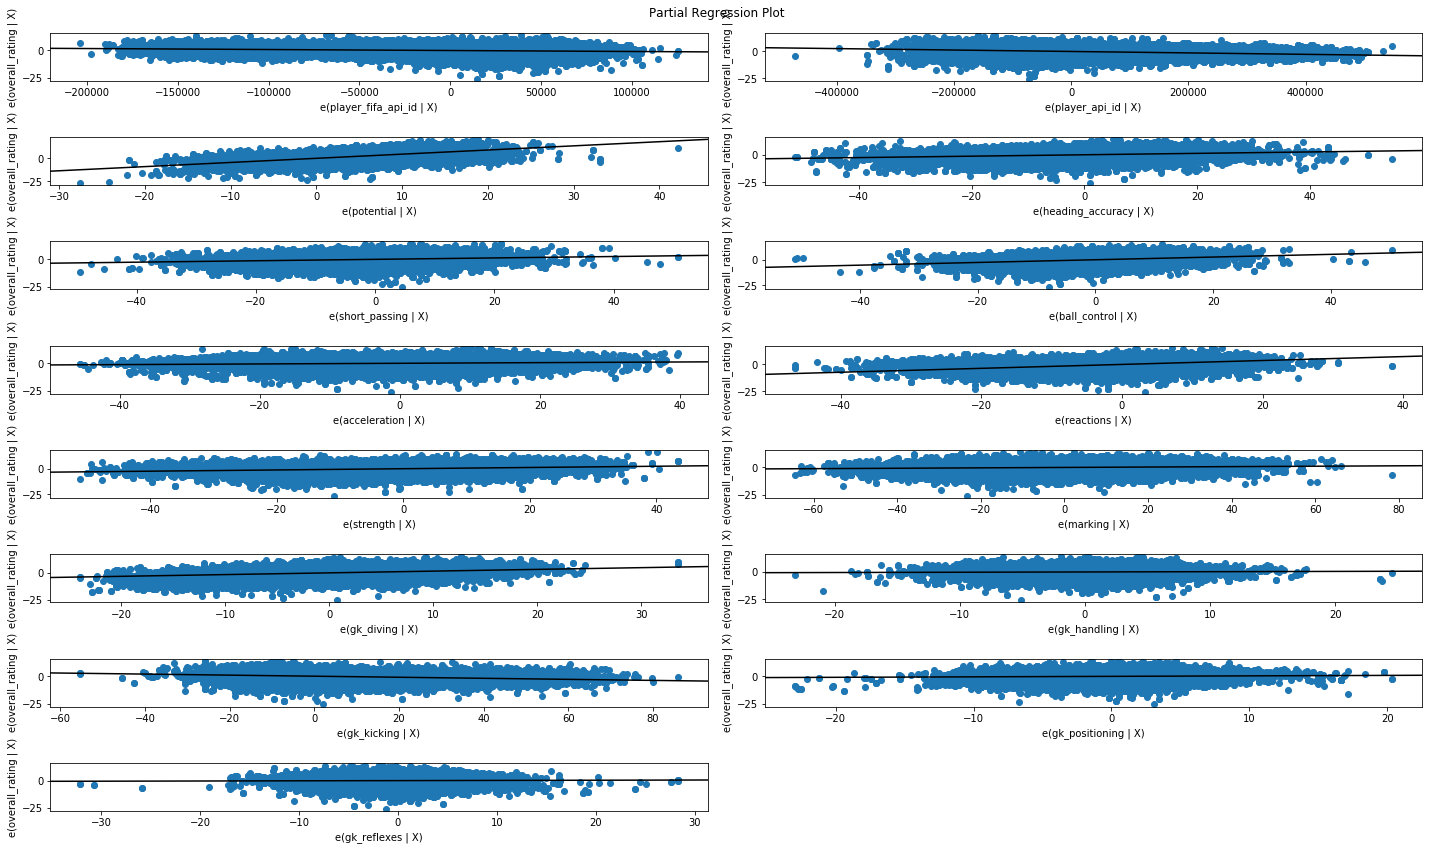

In [74]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(result, fig=fig)

In [75]:
import statsmodels.formula.api as smf
# only include TV and Radio in the model
lm = smf.ols(formula='overall_rating ~  player_fifa_api_id + player_api_id +potential +heading_accuracy +short_passing +ball_control +acceleration +reactions +strength +marking +gk_diving +gk_handling +gk_kicking +gk_positioning +gk_reflexes ', data=df_new).fit()
print('Confidence of the statsmodel for the input data : ',lm.rsquared)

Confidence of the statsmodel for the input data :  0.8561047414083595


In [76]:
df_new.head()

id  player_fifa_api_id  player_api_id  overall_rating  potential  crossing  \
0   1              218353         505942            67.0       71.0      49.0   
1   2              218353         505942            67.0       71.0      49.0   
2   3              218353         505942            62.0       66.0      49.0   
3   4              218353         505942            61.0       65.0      48.0   
4   5              218353         505942            61.0       65.0      48.0   

   finishing  heading_accuracy  short_passing  volleys     ...       vision  \
0       44.0              71.0           61.0     44.0     ...         54.0   
1       44.0              71.0           61.0     44.0     ...         54.0   
2       44.0              71.0           61.0     44.0     ...         54.0   
3       43.0              70.0           60.0     43.0     ...         53.0   
4       43.0              70.0           60.0     43.0     ...         53.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       48.0     65.0             69.0            69.0        6.0   
1       48.0     65.0             69.0            69.0        6.0   
2       48.0     65.0             66.0            69.0        6.0   
3       47.0     62.0             63.0            66.0        5.0   
4       47.0     62.0             63.0            66.0        5.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         11.0        10.0             8.0          8.0  
1         11.0        10.0             8.0          8.0  
2         11.0        10.0             8.0          8.0  
3         10.0         9.0             7.0          7.0  
4         10.0         9.0             7.0          7.0  

[5 rows x 38 columns]

In [77]:
df_optm.head()

player_fifa_api_id  player_api_id  potential  heading_accuracy  \
0              218353         505942       71.0              71.0   
1              218353         505942       71.0              71.0   
2              218353         505942       66.0              71.0   
3              218353         505942       65.0              70.0   
4              218353         505942       65.0              70.0   

   short_passing  ball_control  acceleration  reactions  strength  marking  \
0           61.0          49.0          60.0       47.0      76.0     65.0   
1           61.0          49.0          60.0       47.0      76.0     65.0   
2           61.0          49.0          60.0       47.0      76.0     65.0   
3           60.0          48.0          60.0       46.0      76.0     62.0   
4           60.0          48.0          60.0       46.0      76.0     62.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0

## Data Exploration using visualization

In [78]:
df_corr = df_new.corr()

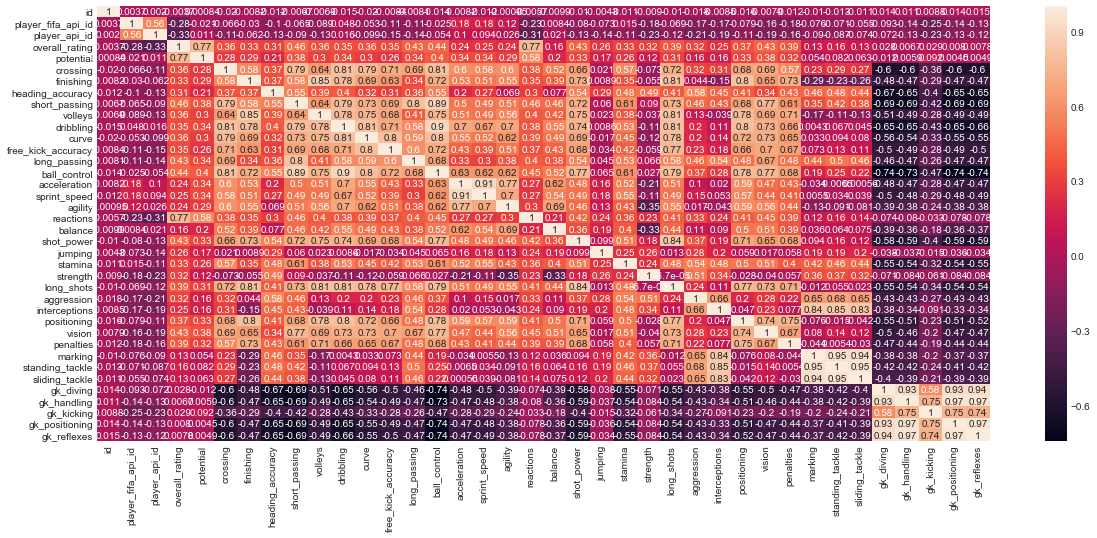

In [79]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(20,8))
sns.heatmap(df_corr,annot=True)































•The features contain high corelation .We need to remove them first before applying Regression Technique

In [80]:
#create correlation matrix with absolute values
df_corr = df_new.corr().abs()
#select upper triangle of matrix
up_tri = df_corr.where(np.triu(np.ones(df_corr.shape[1]),k=1).astype(np.bool))

#find all the features which have a correlation > 0.75 with other features.
corr_features = [ column for column in up_tri.columns if any(up_tri[column]> 0.75)]

#Print Correlated features
print(corr_features)

['potential', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'sprint_speed', 'agility', 'reactions', 'shot_power', 'long_shots', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_handling', 'gk_positioning', 'gk_reflexes']


In [81]:
#Drop Correlated Features
df_no_corr = df_new.drop(corr_features,axis=1)
df_no_corr.head()

id  player_fifa_api_id  player_api_id  overall_rating  crossing  finishing  \
0   1              218353         505942            67.0      49.0       44.0   
1   2              218353         505942            67.0      49.0       44.0   
2   3              218353         505942            62.0      49.0       44.0   
3   4              218353         505942            61.0      48.0       43.0   
4   5              218353         505942            61.0      48.0       43.0   

   heading_accuracy  acceleration  balance  jumping  stamina  strength  \
0              71.0          60.0     65.0     58.0     54.0      76.0   
1              71.0          60.0     65.0     58.0     54.0      76.0   
2              71.0          60.0     65.0     58.0     54.0      76.0   
3              70.0          60.0     65.0     58.0     54.0      76.0   
4              70.0          60.0     65.0     58.0     54.0      76.0   

   aggression  interceptions  gk_diving  gk_kicking  
0        71.0           70.0        6.0        10.0  
1        71.0           70.0        6.0        10.0  
2        63.0           41.0        6.0        10.0  
3        62.0           40.0        5.0         9.0  
4        62.0           40.0        5.0         9.0

In [82]:
len(df_no_corr.columns)

16

•This shows that the feature selection API - sklearn.feature_selection.RFE has resulted in the same feature selection for top 15 features selected.


•Quant Features against Rating

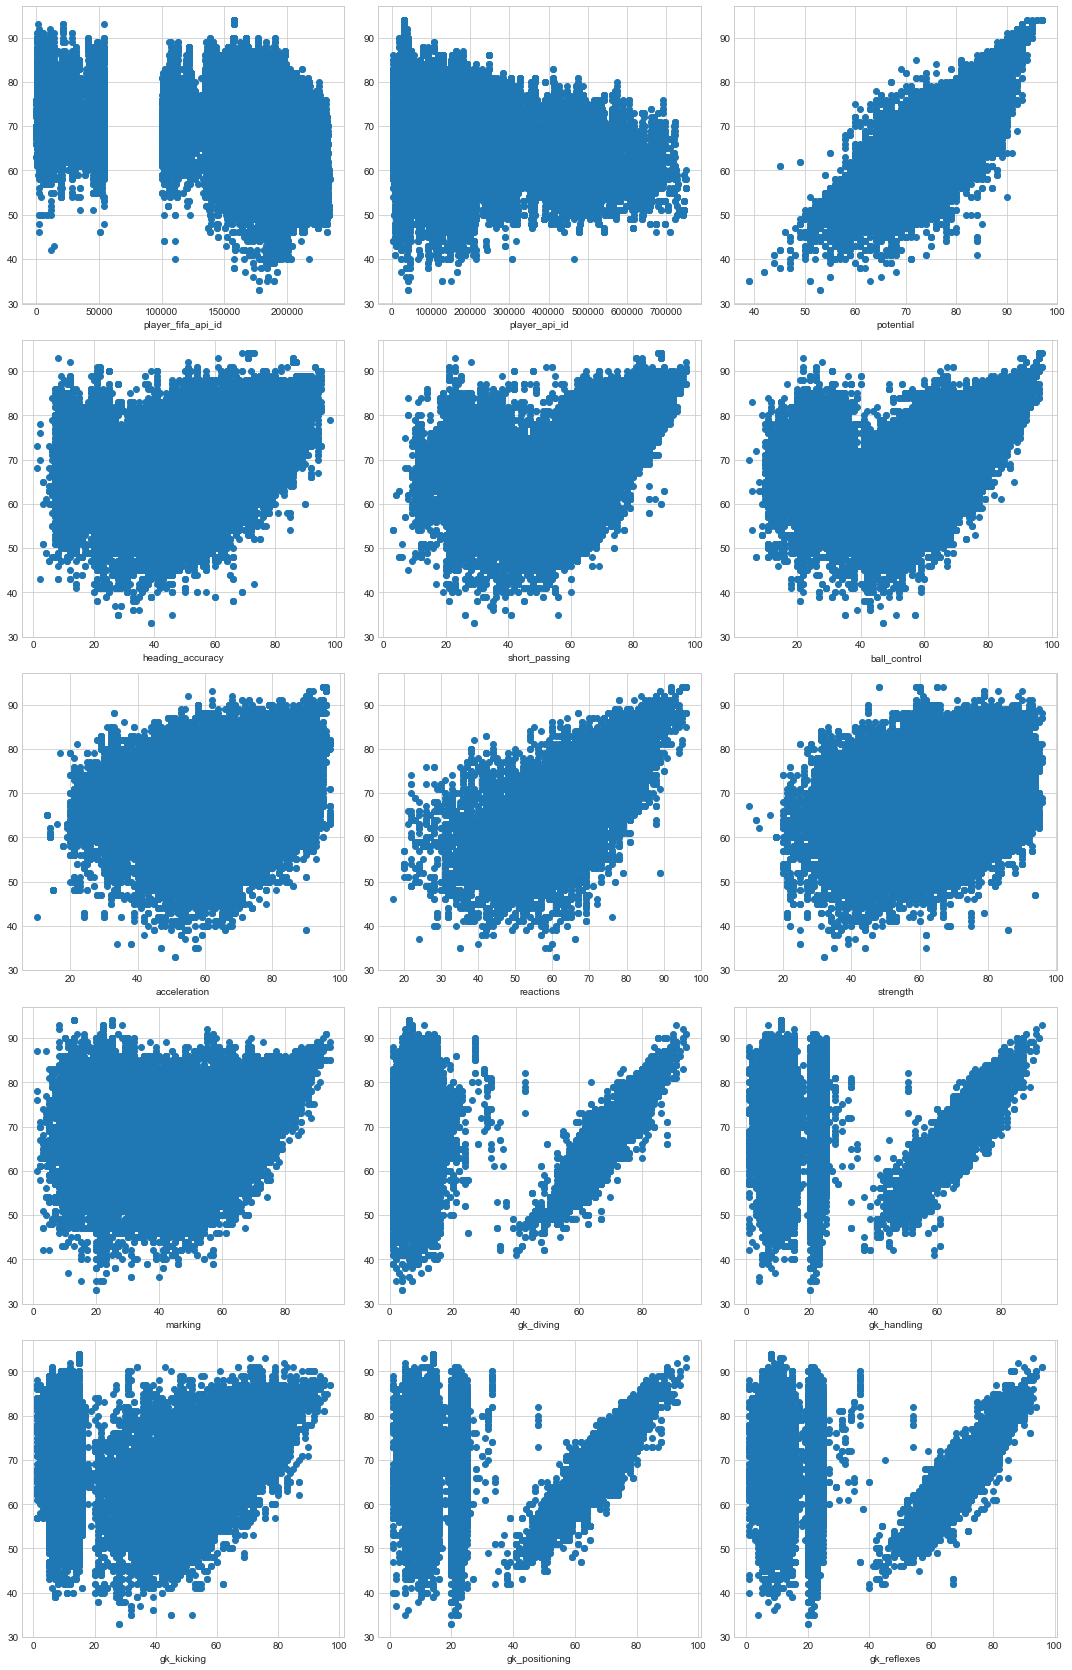

In [85]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,60))
val = df_optm.shape[1]
for idx in range(val):
    feature = df_optm.columns[idx]
    ax = fig.add_subplot(13,3,idx+1)
    Xtmp = df_optm[feature]
    ax.scatter(Xtmp, y)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

## Split the input data into training and test data

In [86]:
from sklearn.model_selection import train_test_split
#spliting 66.66% for train data and 33.33% for test data.
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.33,random_state=0)
print("X_train Shape : ",X_train.shape)
print("X_test Shape : ",X_test.shape)
print("Y_train Shape : ",Y_train.shape)
print("Y_test.shape : ",Y_test.shape)

X_train Shape :  (120837, 37)
X_test Shape :  (59517, 37)
Y_train Shape :  (120837,)
Y_test.shape :  (59517,)


## Applying Linear Regression Model

In [87]:
lm = LinearRegression()
lm.fit(X_train, Y_train)# train the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Perform Prediction using Linear Regression Model

In [88]:
Y_pred = lm.predict(X_test) # predict the prices based on the test data

In [89]:
Y_pred

array([73.74672865, 68.65401302, 67.22132467, ..., 71.6247244 ,
       64.76934151, 62.18654694])

In [90]:
print("The variance score of the LinearRegression model is  : ",lm.score(X_test,Y_test))

The variance score of the LinearRegression model is  :  0.8593275836597537


#### •Since variance score is near about 1 it seems to be a perfect prediction

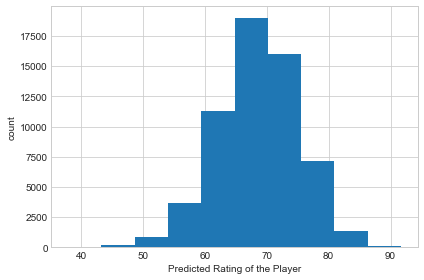

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(Y_pred)
plt.xlabel('Predicted Rating of the Player')
plt.ylabel('count')
plt.tight_layout()

Text(0.5,1,'Actual vs Predicted Rating for LinearRegression Model')

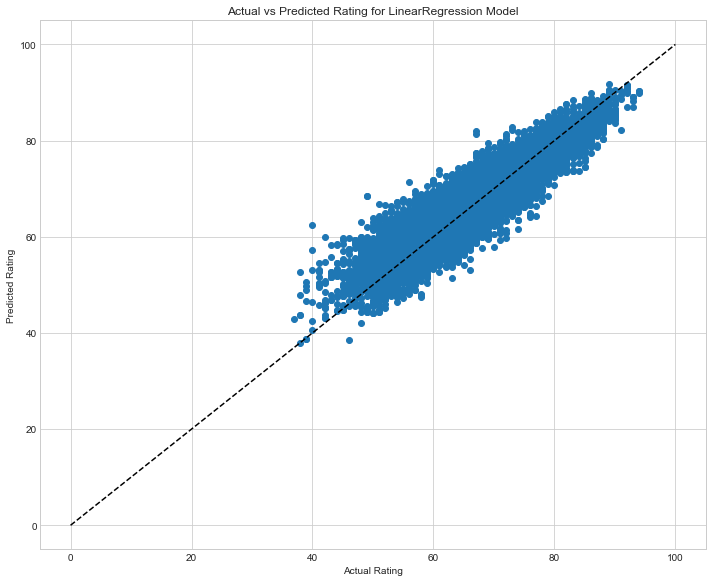

In [92]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(10, 8))
plt.scatter(Y_test, Y_pred)
plt.plot([0, 100], [0, 100], '--k')
plt.axis('tight')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.tight_layout()
plt.title("Actual vs Predicted Rating for LinearRegression Model")

## Evaluate Linear Regression Accuracy using Root Mean Square Error

In [93]:
from sklearn.metrics import mean_squared_error
print("Error Rate of the Regression Model : ",sqrt(mean_squared_error(Y_pred,Y_test)))

Error Rate of the Regression Model :  2.6234739118445694


## Applying Decision Tree Regressor Model to the input data

In [94]:
regressor  = DecisionTreeRegressor(max_depth=20)
regressor.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Perform Prediction using Decision Tree Regressor

In [95]:
Y_pred = regressor.predict(X_test)

In [96]:
Y_pred

array([75.        , 72.        , 67.        , ..., 71.        ,
       62.        , 61.78571429])

In [97]:
print("The variance score of the DecisionTreeRegressor model is  : ",regressor.score(X_test,Y_test))

The variance score of the DecisionTreeRegressor model is  :  0.9546595029375788


#### •Since variance score is near about 1 it seems to be a perfect prediction

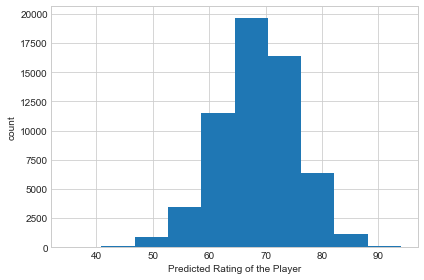

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(Y_pred)
plt.xlabel('Predicted Rating of the Player')
plt.ylabel('count')
plt.tight_layout()

Text(0.5,1,'Actual vs Predicted Rating for DecisionTreeRegressor Model')

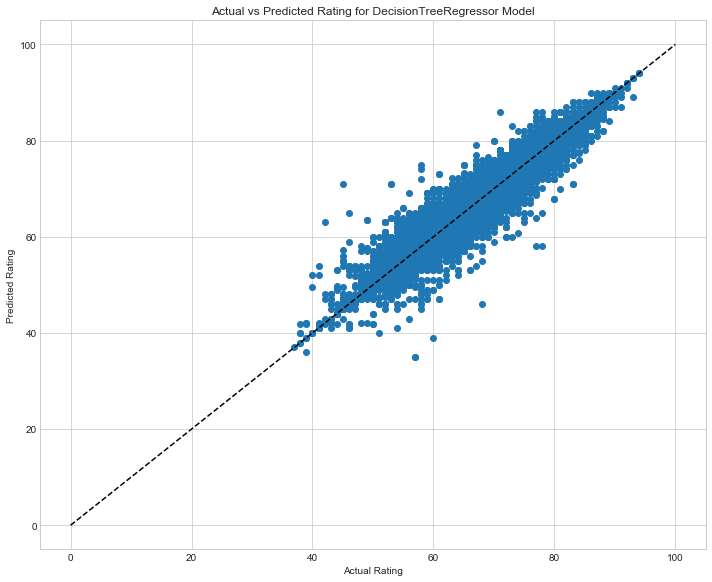

In [99]:
plt.figure(figsize=(10, 8))
plt.scatter(Y_test, Y_pred)
plt.plot([0, 100], [0, 100], '--k')
plt.axis('tight')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.tight_layout()
plt.title("Actual vs Predicted Rating for DecisionTreeRegressor Model")

In [100]:
#The mean of the expected target value in test set 
Y_test.mean()

68.66518809751835

In [101]:
#The mean of the predicted target value in test set ? 
Y_pred.mean()

68.6593066907666

## Evaluate Linear Regression Accuracy using Root Mean Square Error For DecisionTreeRegressor model

In [102]:
print("Error Rate of the DecisionTreeRegressor Model : ",sqrt(mean_squared_error(Y_pred,Y_test)))

Error Rate of the DecisionTreeRegressor Model :  1.4894139412790361


#### •The DecisionTreeRegressor Model performs better than the LinearRegression Model as eveident from the error rate

## Obtaining predictions by cross-validation for the Regression Models

In [103]:
df_optm = df_new.copy()
df_optm['rating'] = y
df_optm.head()

id  player_fifa_api_id  player_api_id  overall_rating  potential  crossing  \
0   1              218353         505942            67.0       71.0      49.0   
1   2              218353         505942            67.0       71.0      49.0   
2   3              218353         505942            62.0       66.0      49.0   
3   4              218353         505942            61.0       65.0      48.0   
4   5              218353         505942            61.0       65.0      48.0   

   finishing  heading_accuracy  short_passing  volleys   ...    penalties  \
0       44.0              71.0           61.0     44.0   ...         48.0   
1       44.0              71.0           61.0     44.0   ...         48.0   
2       44.0              71.0           61.0     44.0   ...         48.0   
3       43.0              70.0           60.0     43.0   ...         47.0   
4       43.0              70.0           60.0     43.0   ...         47.0   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0     65.0             69.0            69.0        6.0         11.0   
1     65.0             69.0            69.0        6.0         11.0   
2     65.0             66.0            69.0        6.0         11.0   
3     62.0             63.0            66.0        5.0         10.0   
4     62.0             63.0            66.0        5.0         10.0   

   gk_kicking  gk_positioning  gk_reflexes  rating  
0        10.0             8.0          8.0    67.0  
1        10.0             8.0          8.0    67.0  
2        10.0             8.0          8.0    62.0  
3         9.0             7.0          7.0    61.0  
4         9.0             7.0          7.0    61.0  

[5 rows x 39 columns]

In [104]:
from sklearn.model_selection import cross_val_predict
X = df_optm.drop('rating',axis=1)
Y = df_optm['rating']
predicted = cross_val_predict(regressor, X, Y, cv=10)

In [105]:
from sklearn.metrics import accuracy_score
print( "Accuracy Score of the DecisionTreeRegressor Model is  : " ,accuracy_score(Y.astype(int), predicted) )

Accuracy Score of the DecisionTreeRegressor Model is  :  0.9998003925612962


## Calculate Error using K-Fold Cross validation

In [106]:
from sklearn.cross_validation import KFold
kfold = KFold(len(df_optm),n_folds=10,shuffle=True,random_state=0)

In [107]:
from sklearn.metrics import mean_absolute_error
lm = LinearRegression()
mean_abs_error = []
accuracy_score = []
for train,test in kfold:
    x = X.iloc[train]
    y = Y.iloc[train]
    lm.fit(x,y)
    Y_test = Y.iloc[test]
    Y_pred = lm.predict(X.iloc[test])
    mean_abs_error.append(mean_absolute_error(Y_test,Y_pred))

In [108]:
print('10 Fold Cross Validation Error : {} accuracy score : {}  for LinearRegression Model '.format(np.mean(mean_abs_error),1 - np.mean(mean_abs_error)))

10 Fold Cross Validation Error : 3.659946305405014e-12 accuracy score : 0.99999999999634  for LinearRegression Model 


## CONCLUSION :

We have use the below models to predict the player ratings.
    •statsmodels.api.OLS
    •LinearRegression
    •DecisionTreeRegressor

Sampling Mechanisms used:-
    •Test Train Split
    •10 Fold Cross Validation

Model Estimation mechanisms used:
    •Root Mean Squared Error
    •10 Fold Cross Validation error.


# Alternative - 2

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

In [110]:
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

# Data Preparation

In [111]:
df.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

      ...       vision  penalties  marking  standing_tackle  sliding_tackle  \
0     ...         54.0       48.0     65.0             69.0            69.0   
1     ...         54.0       48.0     65.0             69.0            69.0   
2     ...         54.0       48.0     65.0             66.0            69.0   
3     ...         53.0       47.0     62.0             63.0            66.0   
4     ...         53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

In [112]:
df.describe()

id  player_fifa_api_id  player_api_id  overall_rating  \
count  183978.00000       183978.000000  183978.000000   183142.000000   
mean    91989.50000       165671.524291  135900.617324       68.600015   
std     53110.01825        53851.094769  136927.840510        7.041139   
min         1.00000            2.000000    2625.000000       33.000000   
25%     45995.25000       155798.000000   34763.000000       64.000000   
50%     91989.50000       183488.000000   77741.000000       69.000000   
75%    137983.75000       199848.000000  191080.000000       73.000000   
max    183978.00000       234141.000000  750584.000000       94.000000   

           potential       crossing      finishing  heading_accuracy  \
count  183142.000000  183142.000000  183142.000000     183142.000000   
mean       73.460353      55.086883      49.921078         57.266023   
std         6.592271      17.242135      19.038705         16.488905   
min        39.000000       1.000000       1.000000          1.000000   
25%        69.000000      45.000000      34.000000         49.000000   
50%        74.000000      59.000000      53.000000         60.000000   
75%        78.000000      68.000000      65.000000         68.000000   
max        97.000000      95.000000      97.000000         98.000000   

       short_passing        volleys      ...               vision  \
count  183142.000000  181265.000000      ...        181265.000000   
mean       62.429672      49.468436      ...            57.873550   
std        14.194068      18.256618      ...            15.144086   
min         3.000000       1.000000      ...             1.000000   
25%        57.000000      35.000000      ...            49.000000   
50%        65.000000      52.000000      ...            60.000000   
75%        72.000000      64.000000      ...            69.000000   
max        97.000000      93.000000      ...            97.000000   

           penalties        marking  standing_tackle  sliding_tackle  \
count  183142.000000  183142.000000    183142.000000   181265.000000   
mean       55.003986      46.772242        50.351257       48.001462   
std        15.546519      21.227667        21.483706       21.598778   
min         2.000000       1.000000         1.000000        2.000000   
25%        45.000000      25.000000        29.000000       25.000000   
50%        57.000000      50.000000        56.000000       53.000000   
75%        67.000000      66.000000        69.000000       67.000000   
max        96.000000      96.000000        95.000000       95.000000   

           gk_diving    gk_handling     gk_kicking  gk_positioning  \
count  183142.000000  183142.000000  183142.000000   183142.000000   
mean       14.704393      16.063612      20.998362       16.132154   
std        16.865467      15.867382      21.452980       16.099175   
min         1.000000       1.000000       1.000000        1.000000   
25%         7.000000       8.000000       8.000000        8.000000   
50%        10.000000      11.000000      12.000000       11.000000   
75%        13.000000      15.000000      15.000000       15.000000   
max        94.000000      93.000000      97.000000       96.000000   

         gk_reflexes  
count  183142.000000  
mean       16.441439  
std        17.198155  
min         1.000000  
25%         8.000000  
50%        11.000000  
75%        15.000000  
max        96.000000  

[8 rows x 38 columns]

In [113]:
target = df.pop('overall_rating')

In [114]:
df.shape

(183978, 41)

In [115]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

## Handling Missing Values

In [116]:
target.isnull().values.sum()

836

In [117]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

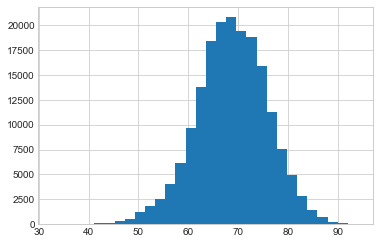

In [118]:
plt.hist(target, 30, range=(33, 94))

#### almost normal distribution so we can impute mean value for missing value in target

In [119]:
y = target.fillna(target.mean())

In [120]:
y.isnull().values.any()

False

## Data Exploration :

In [121]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 41 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint

In [123]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}".format(col=col, unique_cat=unique_cat,))

id--> 183978
player_fifa_api_id--> 11062
player_api_id--> 11060
date--> 197
potential--> 57
preferred_foot--> 3
attacking_work_rate--> 9
defensive_work_rate--> 20
crossing--> 96
finishing--> 98
heading_accuracy--> 97
short_passing--> 96
volleys--> 94
dribbling--> 98
curve--> 93
free_kick_accuracy--> 98
long_passing--> 96
ball_control--> 94
acceleration--> 87
sprint_speed--> 86
agility--> 82
reactions--> 79
balance--> 82
shot_power--> 97
jumping--> 80
stamina--> 85
strength--> 83
long_shots--> 97
aggression--> 92
interceptions--> 97
positioning--> 96
vision--> 98
penalties--> 95
marking--> 96
standing_tackle--> 96
sliding_tackle--> 95
gk_diving--> 94
gk_handling--> 91
gk_kicking--> 98
gk_positioning--> 95
gk_reflexes--> 93


we can see only four features have the type 'object'. here the feature named 'date' has no significance in this problem so can ignore it and perform one hot encoding on the rest of 3 features

In [124]:
## here the feature named 'date' has no significance in this problem so can ignore it and perform one hot encoding on the rest of 3 features.
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

id  player_fifa_api_id  player_api_id                 date  potential  \
0   1              218353         505942  2016-02-18 00:00:00       71.0   
1   2              218353         505942  2015-11-19 00:00:00       71.0   
2   3              218353         505942  2015-09-21 00:00:00       66.0   
3   4              218353         505942  2015-03-20 00:00:00       65.0   
4   5              218353         505942  2007-02-22 00:00:00       65.0   

   crossing  finishing  heading_accuracy  short_passing  volleys  \
0      49.0       44.0              71.0           61.0     44.0   
1      49.0       44.0              71.0           61.0     44.0   
2      49.0       44.0              71.0           61.0     44.0   
3      48.0       43.0              70.0           60.0     43.0   
4      48.0       43.0              70.0           60.0     43.0   

             ...              defensive_work_rate_9  defensive_work_rate__0  \
0            ...                                  0                       0   
1            ...                                  0                       0   
2            ...                                  0                       0   
3            ...                                  0                       0   
4            ...                                  0                       0   

   defensive_work_rate_ean  defensive_work_rate_es  defensive_work_rate_high  \
0                        0                       0                         0   
1                        0                       0                         0   
2                        0                       0                         0   
3                        0                       0                         0   
4                        0                       0                         0   

   defensive_work_rate_low  defensive_work_rate_medium  defensive_work_rate_o  \
0                        0                           1                      0   
1                        0                           1                      0   
2                        0                           1                      0   
3                        0                           1                      0   
4                        0                           1                      0   

   defensive_work_rate_ormal  defensive_work_rate_tocky  
0                          0                          0  
1                          0                          0  
2                          0                          0  
3                          0                          0  
4                          0                          0  

[5 rows x 67 columns]

In [125]:
X = dummy_df.drop(['id', 'date'], axis=1)

## Feature selection :

•As tree model doesn't gets affected by missing values present in data set. but feature selection by SelectFrom Model can not be done on datasets that carries null value. Therefore, we should also perform imputation on dataset. 

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [127]:
#Imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [128]:
#Finding feature_importance for feature selection. from it we'll be able to decide threshold value
model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[0.01714286 0.02       0.10714286 0.02       0.04714286 0.03571429
 0.03285714 0.         0.04       0.         0.         0.00714286
 0.04714286 0.01       0.01571429 0.00142857 0.18571429 0.
 0.01428571 0.00571429 0.00857143 0.03142857 0.00571429 0.00714286
 0.01857143 0.01857143 0.00571429 0.         0.04285714 0.04571429
 0.01       0.04571429 0.02571429 0.02428572 0.06       0.04285714
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [129]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [130]:
select_X_train.shape

(137983, 24)

## Training different models :

## 1. Linear Regression :

In [131]:
pipe = make_pipeline(StandardScaler(),             #preprocessing(standard scalling)
                     LinearRegression())           #estimator(linear regression)

cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     #parameters for model tunning

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [132]:
grid.fit(select_X_train, y_train)          #training 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [133]:
grid.best_params_

{'linearregression__n_jobs': -1}

In [134]:
lin_reg = pickle.dumps(grid)

## 2. Decision Tree :

In [135]:
pipe = make_pipeline(StandardScaler(),                  #preprocessing
                     DecisionTreeRegressor(criterion='mse', random_state=0))          #estimator

cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [136]:
grid.fit(select_X_train, y_train)          #training 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [137]:
grid.best_params_

{'decisiontreeregressor__max_depth': 13}

In [138]:
Dectree_reg = pickle.dumps(grid)

## Comparision between different models :

In [139]:
lin_reg = pickle.loads(lin_reg)
Dectree_reg = pickle.loads(Dectree_reg)
#Randfor_reg = pickle.loads(Randfor_reg)
#xgbreg = pickle.loads(xgbreg)

In [140]:
print("""Linear Regressor accuracy is {lin} DecisionTree Regressor accuracy is {Dec}""".format(lin=lin_reg.score(select_X_test, y_test),Dec=Dectree_reg.score(select_X_test, y_test)))

Linear Regressor accuracy is 0.8547439877398585 DecisionTree Regressor accuracy is 0.9300656646020649


By accuracy comparision performed above we can say hear that DecisionTree Regressor gives better result than any other model. and it can predict the target function with approx 98% accuracy.